# Introduction

Autocorrelation analysis is an important step in the Exploratory Data Analysis (EDA) of time series. **The autocorrelation analysis helps in detecting hidden patterns and seasonality and in checking for randomness.**
It is especially important when you intend to use an ARIMA model for forecasting because the autocorrelation analysis helps to identify the AR and MA parameters for the ARIMA model.

**Overview**
* [Fundamentals](#Fundamentals)<br>
    * [Auto-Regressive and Moving Average Models](#[Auto-Regressive-and-Moving-Average-Models])<br>
    * [Stationarity](#Stationarity)<br>
    * [Autocorrelation Function and Partial Autocorrelation Function](#Autocorrelation-Function-and-Partial-Autocorrelation-Function)<br>
    * [Order of AR, MA, and ARMA Model](#Order-of-AR-MA-and-ARMA-Model)
* [Examples](#Examples)<br>
    * [AR(1) Process](#AR(1%29-Process)<br>
    * [AR(2) Process](#AR(2%29-Process)<br>
    * [MA(1) Process](#MA(1%29-Process)<br>
    * [MA(2) Process](#MA(2%29-Process)<br>
    * [Periodical](#Periodical)<br>
    * [Trend](#Trend)<br>
    * [White Noise](#White-Noise)<br>
    * [Random-Walk](#Random-Walk)<br>
    * [Constant](#Constant)<br>
* [🚀 Cheat Sheet](#🚀-Cheat-Sheet)<br>
* [Case Study](#Case-Study)<br>
    * [Bitcoin](#Bitcoin)<br>  
    * [Ethereum](#Ethereum)<br> 
    * [Discussion on Random-Walk](#Discussion-on-Random-Walk)<br> 
    
If you need some introduction to or a refresher on the ACF and PACF, I recommend the following video:
<iframe width="700" height="400" src="https://www.youtube.com/embed/DeORzP0go5I" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [1]:
import numpy as np # linear algebra
from numpy.random import seed 
import math 

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from datetime import datetime, date 

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
import seaborn as sns

import warnings # Supress warnings 
warnings.filterwarnings('ignore')

import statsmodels as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARMA

# Fix seed for reproducible results
SEED = 42
np.random.seed(SEED)

# Visualizations
lag_acf = 15
lag_pacf = 15
height = 4
width = 12

# Fundamentals

## Auto-Regressive and Moving Average Models

### Auto-Regressive (AR) Model

$\hat{y}_t = \alpha_1 y_{t-1} + \dots + {\alpha_p}y_{t-p}$

The AR model assumes that the current value ($y_t$) is **dependent on previous values** ($y_{t-1}, y_{t-2}, y_{t-3},...$). Because of this assumption, we can build a **linear** regression model.

To figure out the order of an AR model, you would use the **PACF**.

### Moving Average (MA) Model

$\hat{y}_t = \epsilon_t + \beta_1 \epsilon_{t-1} + \dots + \beta_{q} \epsilon_{t-q}$

The MA model assumes that the current value ($y_t$) is **dependent on the error terms** including the current error ($\epsilon_{t}, \epsilon_{t-1}, \epsilon_{t-2}, \epsilon_{t-3},...$). Because error terms are random, there is **no linear** relationship between the current value and the error terms.

To figure out the order of an MA model, you would use the **ACF**.

## Stationarity

ACF and PACF assume stationarity of the underlying time series.
Staionarity can be checked by performing an **Augmented Dickey-Fuller (ADF) test**:

> - p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
> - p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.
>
> [...] We can see that our [ADF] statistic value [...] is less than the value [...] at 1%.
This suggests that we can reject the null hypothesis with a significance level of less than 1% (i.e. a low probability that the result is a statistical fluke).
Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure. - [Machine Learning Mastery: How to Check if Time Series Data is Stationary with Python](https://machinelearningmastery.com/time-series-data-stationary-python/)

If the time series is stationary, continue to the next steps.
**If the time series is not stationary, try differencing the time series** and check its stationarity again.


In [2]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

## Autocorrelation Function and Partial Autocorrelation Function

### Autocorrelation Function (ACF)

Correlation between time series with a lagged version of itself. The correlation between the observation at the current time spot and the observations at previous time spots.The autocorrelation function starts a lag 0, which is the correlation of the time series with itself and therefore results in a correlation of 1.

We will be using the `plot_acf` function from the `statsmodels.graphics.tsaplots` library. (See [statsmodels.tsa.stattools.acf](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.acf.html))

The ACF plot can provide answers to the following questions:
- Is the observed time series **white noise / random**?
- Is an observation related to an adjacent observation, an observation twice-removed, and so on? 
- Can the observed time series be modeled with an **MA model**? If yes, what is the order?



### Partial Autocorrelation Function (PACF)
Additional correlation explained by each successive lagged term. The correlation between pbservations at two time spots given that we consider both observations are correlated to observations at other time spots.
> The partial autocorrelation at lag k is the autocorrelation between $X_t$ and $X_{t−k}$ that is not accounted for by lags 1 through $k−1$. 

We will be using the `plot_pacf` function from the `statsmodels.graphics.tsaplots` library with the parameter `method = "ols"` (regression of time series on lags of it and on constant). (See [statsmodels.tsa.stattools.pacf](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.pacf.html))

Sidenote: The default parameter for `method` is `yw` (Yule-Walker with sample-size adjustment in denominator for acovf). However, this default value is causing some implausible autocorrelations higher than 1 on the sample data. Therefore, we change the `method` parameter to one that is not causing this issue. `ywmle` would also work fine as suggested in this [StackExchange post](https://stats.stackexchange.com/questions/380196/what-do-very-high-pacf-values-10-mean)

The PACF plot can provide answers to the following questions:
- Can the observed time series be modeled with an **AR model**? If yes, what is the order?

In [3]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

Both the ACF and PACF start with a **lag of 0**, which is the correlation of the time series with itself and therefore results in a **correlation of 1**.

The difference between ACF and PACF is the inclusion or exclusion of indirect correlations in the calculation.

Furthermore, you will see a **blue area** in the ACF and PACF plots, which depicts the 95% confidence interval and is in indicator for the **significance threshold**. That means, anything within the blue area is statistically close to zero and anything outside the blue area is statistically non-zero.

## Order of AR, MA, and ARMA Model
To determine the order of the model, you can use the following table:

| | AR($p$) | MA($q$) | ARMA($p$, $q$) |
|-|-|-|-|
|ACF|Tails off (Geometric decay) | Significant at lag $q$ / Cuts off after lag $q$|Tails off (Geometric decay) |
|PACF| Significant at each lag $p$ / Cuts off after lag $p$|Tails off (Geometric decay) |Tails off (Geometric decay) |

To build some intuition about how to determine the order of an AR or MA model, I recommend this video:
<iframe width="700" height="400" src="https://www.youtube.com/embed/ZE_WGBe0_VU" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

# Examples

## AR(1) Process
The following time series is an AR(1) process with 128 timesteps and the following parameters:

In [4]:
alpha_1 = 0.5

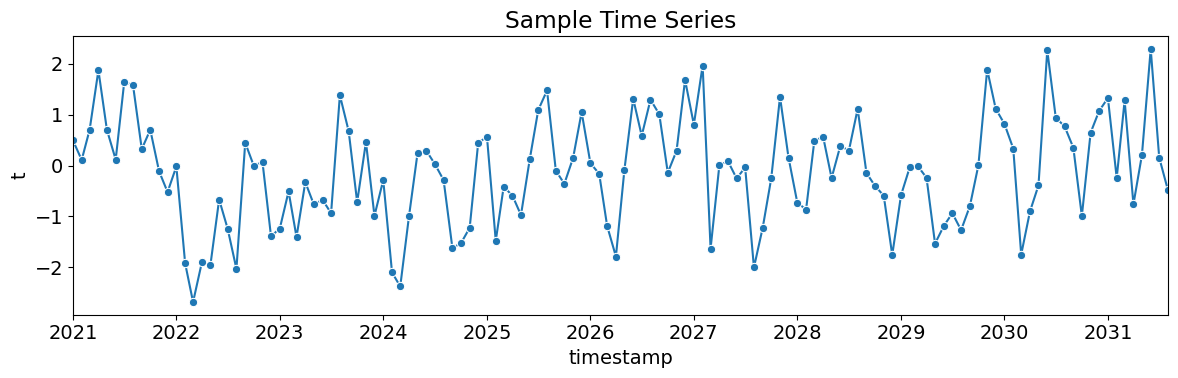

In [5]:
num_samples =  128

np.random.seed(SEED)
ar = np.r_[1, -np.array([alpha_1])] # add zero-lag and negate
ma = np.r_[1] # add zero-lag

sample = pd.DataFrame({'timestamp' : pd.date_range('2021-01-01', periods=num_samples, freq='MS'),
                       't' : sm.tsa.arima_process.arma_generate_sample(ar, ma, num_samples)
                      })

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))

sns.lineplot(x=sample.timestamp, y=sample['t'], marker='o')
ax.set_xlim([sample.timestamp.iloc[0], sample.timestamp.iloc[-1]])
ax.set_title('Sample Time Series')
plt.tight_layout()
plt.show()

### 1. Check Stationarity
The sample data is stationary. Therefore, we do not need to difference the time series.

In [6]:
check_stationarity(sample['t'])

ADF Statistic: -6.918528
p-value: 0.000000
Critical Values:
	1%: -3.483
	5%: -2.885
	10%: -2.579
Stationary


### 2. Check ACF and PACF

We can make the following observations:
- There are several autocorrelations that are significantly non-zero. Therefore, the time series is non-random.
- High degree of autocorrelation between adjacent (lag = 1)

| | AR($p$) | MA($q$) | ARMA($p$, $q$) |
|-|-|-|-|
|ACF|Tails off (Geometric decay) |Significant at lag $q$ / Cuts off after lag $q$  |Tails off (Geometric decay) |
|PACF| <span style= 'background:yellow'> Significant at each lag $p$ / Cuts off after lag $p$ </span>|Tails off (Geometric decay) |Tails off (Geometric decay) |

-> We can use an **AR(1) model** to model this process.

So that for AR(1), we would model the AR(p) formula
$\hat{y}_t = \alpha_1 y_{t-1} + \dots + {\alpha_p}y_{t-p}$
to the following:

$\hat{y}_t = \alpha_1 y_{t-1}$


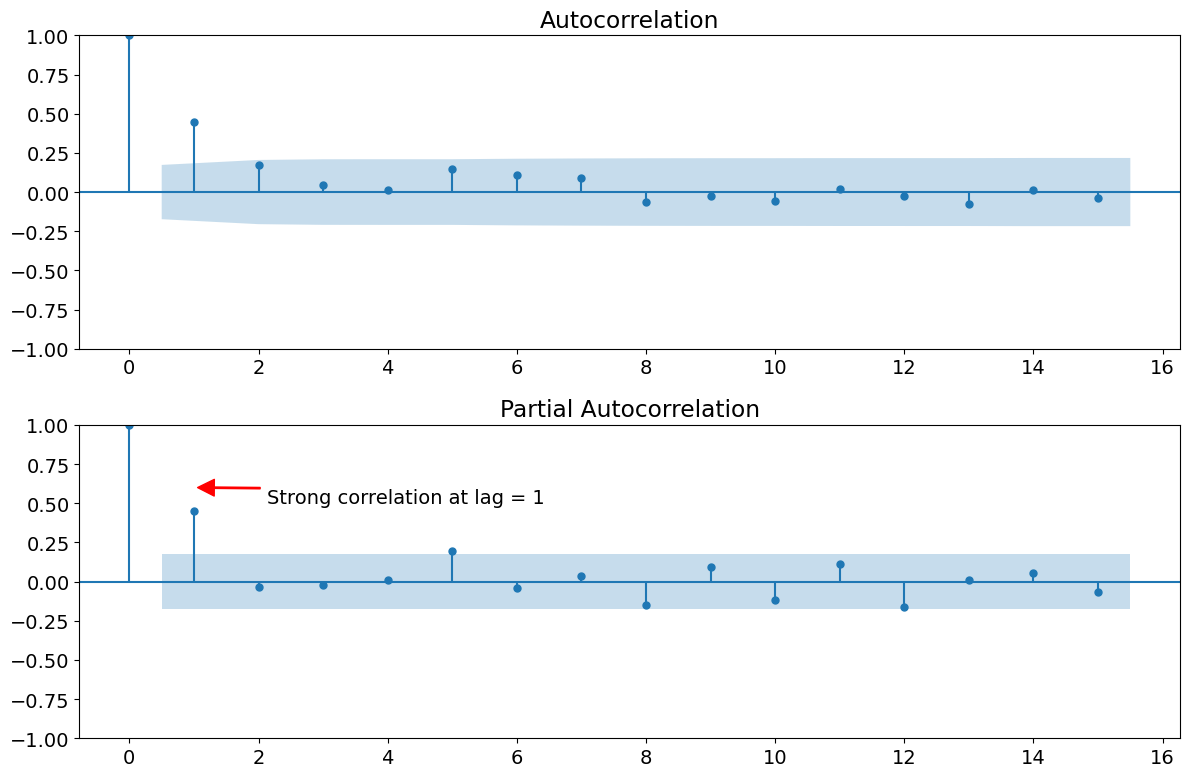

In [7]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(width, 2*height))
plot_acf(sample['t'],lags=lag_acf, ax=ax[0])
plot_pacf(sample['t'],lags=lag_pacf, ax=ax[1], method='ols')

ax[1].annotate('Strong correlation at lag = 1', xy=(1, 0.6),  xycoords='data',
            xytext=(0.17, 0.75), textcoords='axes fraction',
            arrowprops=dict(color='red', shrink=0.05, width=1))

plt.tight_layout()
plt.show()

### 3. Modelling

                            AutoReg Model Results                             
Dep. Variable:                      t   No. Observations:                  102
Model:                     AutoReg(1)   Log Likelihood                -133.385
Method:               Conditional MLE   S.D. of innovations              0.906
Date:                Mon, 10 Jul 2023   AIC                            272.769
Time:                        10:00:03   BIC                            280.615
Sample:                             1   HQIC                           275.945
                                  102                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1322      0.092     -1.434      0.152      -0.313       0.048
t.L1           0.4710      0.088      5.353      0.000       0.299       0.643
                                    Roots           

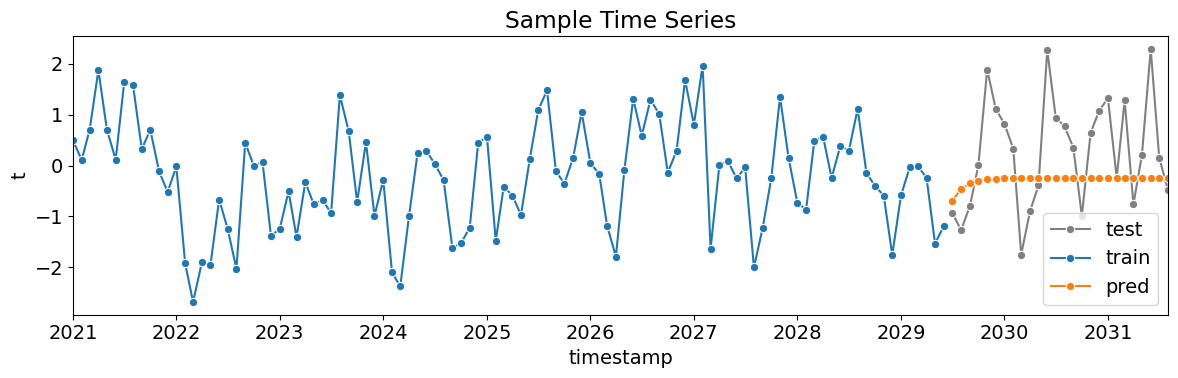

In [8]:
train_len = int(0.8* num_samples)

train = sample['t'][:train_len]
ar_model = AutoReg(train, lags=1).fit()

print(ar_model.summary())
pred = ar_model.predict(start=train_len, end=num_samples, dynamic=False)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
sns.lineplot(x=sample.timestamp[train_len:num_samples], y=sample.t[train_len:num_samples], marker='o', label='test', color='grey')
sns.lineplot(x=sample.timestamp[:train_len], y=train, marker='o', label='train')
sns.lineplot(x=sample.timestamp[train_len:num_samples], y=pred, marker='o', label='pred')
ax.set_xlim([sample.timestamp.iloc[0], sample.timestamp.iloc[-1]])
ax.set_title('Sample Time Series')
plt.tight_layout()
plt.show()

As you can see, the AR(1) model fits an $\alpha_1 = 0.4710$, which is quite close to the `alpha_1 = 0.5` which we have set. However, the predicted values seem to be quite off in this case.

## AR(2) Process
The following time series is an AR(2) process with 128 timesteps and the following parameters:

In [9]:
alpha_1 = 0.5
alpha_2 = -0.5

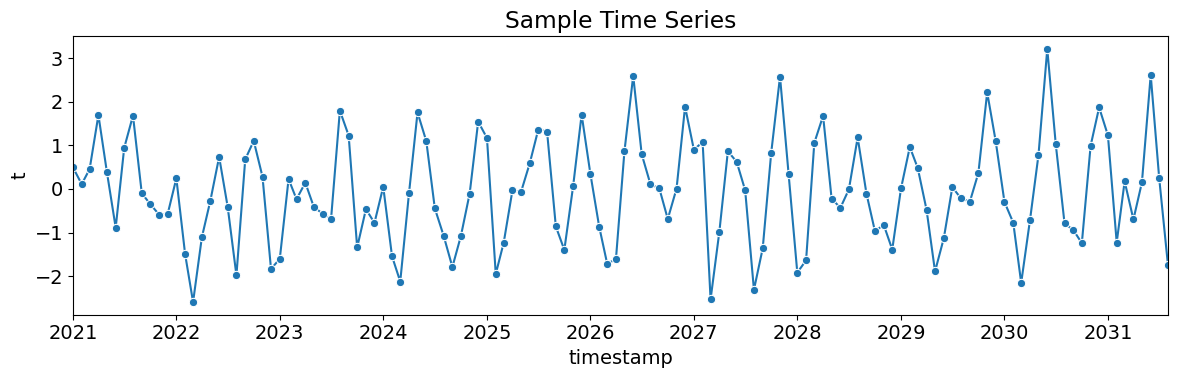

In [10]:
np.random.seed(SEED)
ar = np.r_[1, -np.array([alpha_1, alpha_2])] # add zero-lag and negate
ma = np.r_[1] # add zero-lag

sample = pd.DataFrame({'timestamp' : pd.date_range('2021-01-01', periods=num_samples, freq='MS'),
                       't' : sm.tsa.arima_process.arma_generate_sample(ar, ma, num_samples)
                      })

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))

sns.lineplot(x=sample.timestamp, y=sample['t'], marker='o')
ax.set_xlim([sample.timestamp.iloc[0], sample.timestamp.iloc[-1]])
ax.set_title('Sample Time Series')
plt.tight_layout()
plt.show()

### 1. Check Stationarity
The sample data is stationary. Therefore, we do not need to difference the time series.

In [11]:
check_stationarity(sample['t'])

ADF Statistic: -9.171375
p-value: 0.000000
Critical Values:
	1%: -3.484
	5%: -2.885
	10%: -2.579
Stationary


### 2. Check ACF and PACF

We can make the following observations:
- There are several autocorrelations that are significantly non-zero. Therefore, the time series is non-random.
- High degree of autocorrelation between adjacent (lag = 1) and near-adjacent (lag = 2) observations

| | AR($p$) | MA($q$) | ARMA($p$, $q$) |
|-|-|-|-|
|ACF|Tails off (Geometric decay) |Significant at lag $q$ / Cuts off after lag $q$  |Tails off (Geometric decay) |
|PACF| <span style= 'background:yellow'> Significant at each lag $p$ / Cuts off after lag $p$ </span>|Tails off (Geometric decay) |Tails off (Geometric decay) |

-> We can use an **AR(2) model** to model this process.

So that for AR(2), we would model the AR(p) formula
$\hat{y}_t = \alpha_1 y_{t-1} + \dots + {\alpha_p}y_{t-p}$
to the following:

$\hat{y}_t = \alpha_1 y_{t-1} + \alpha_2 y_{t-2} $


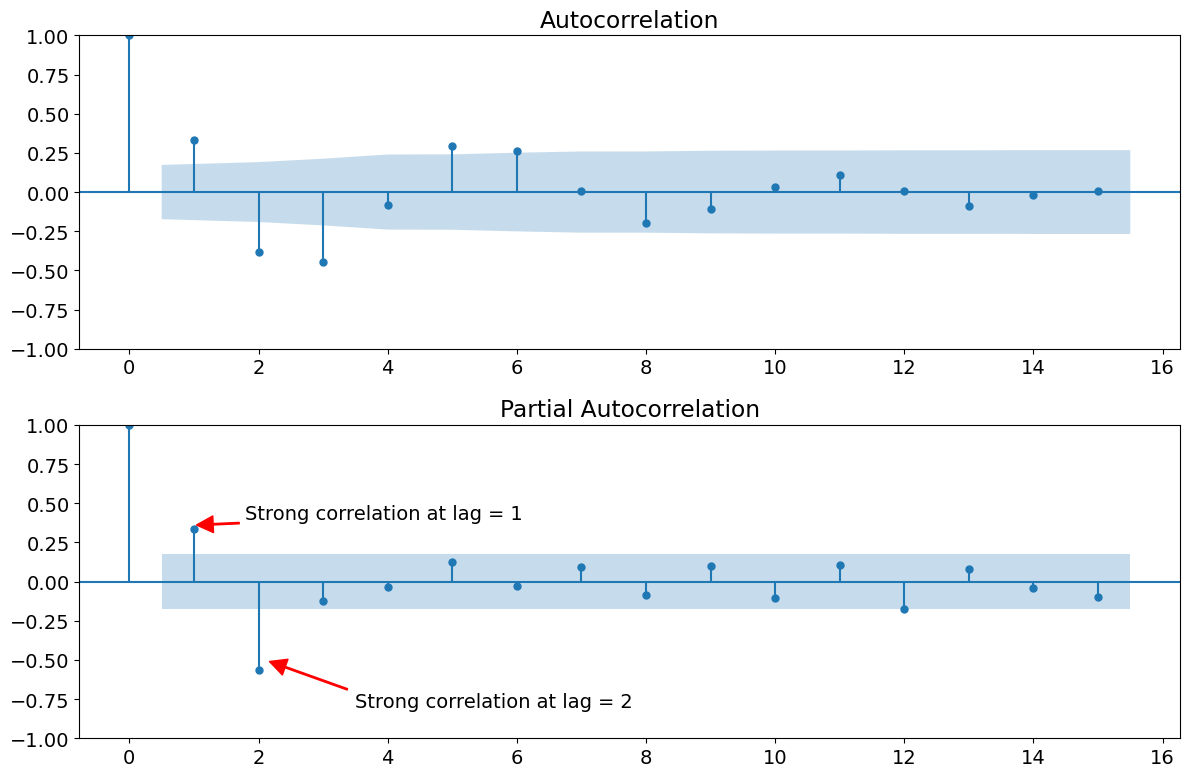

In [12]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(width, 2*height))
plot_acf(sample['t'],lags=lag_acf, ax=ax[0])
plot_pacf(sample['t'],lags=lag_pacf, ax=ax[1], method='ols')

ax[1].annotate('Strong correlation at lag = 1', xy=(1, 0.36),  xycoords='data',
            xytext=(0.15, 0.7), textcoords='axes fraction',
            arrowprops=dict(color='red', shrink=0.05, width=1))

ax[1].annotate('Strong correlation at lag = 2', xy=(2.1, -0.5),  xycoords='data',
            xytext=(0.25, 0.1), textcoords='axes fraction',
            arrowprops=dict(color='red', shrink=0.05, width=1))

plt.tight_layout()
plt.show()

### 3. Modelling

                            AutoReg Model Results                             
Dep. Variable:                      t   No. Observations:                  102
Model:                     AutoReg(2)   Log Likelihood                -132.075
Method:               Conditional MLE   S.D. of innovations              0.906
Date:                Mon, 10 Jul 2023   AIC                            272.150
Time:                        10:00:07   BIC                            282.570
Sample:                             2   HQIC                           276.367
                                  102                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1321      0.091     -1.446      0.148      -0.311       0.047
t.L1           0.5191      0.082      6.363      0.000       0.359       0.679
t.L2          -0.5855      0.082     -7.103      0.0

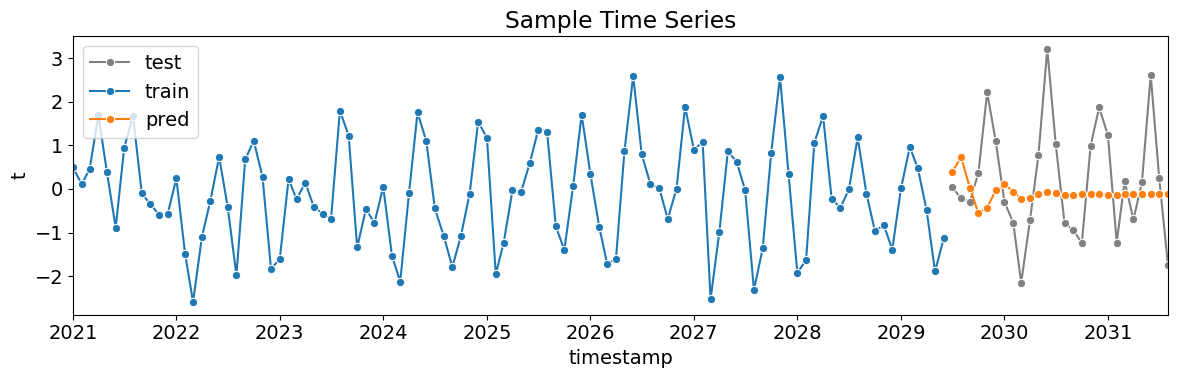

In [13]:
train = sample['t'][:train_len]
ar_model = AutoReg(train, lags=2).fit()

print(ar_model.summary())
pred = ar_model.predict(start=train_len, end=num_samples, dynamic=False)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
sns.lineplot(x=sample.timestamp[train_len:num_samples], y=sample.t[train_len:num_samples], marker='o', label='test', color='grey')
sns.lineplot(x=sample.timestamp[:train_len], y=train, marker='o', label='train')
sns.lineplot(x=sample.timestamp[train_len:num_samples], y=pred, marker='o', label='pred')
ax.set_xlim([sample.timestamp.iloc[0], sample.timestamp.iloc[-1]])
ax.set_title('Sample Time Series')
plt.tight_layout()
plt.show()

As you can see, the AR(2) model fits $\alpha_1 = 0.5191$ and $\alpha_2 = -0.5855$, which is quite close to the `alpha_1 = 0.5` and `alpha_2 = -0.5` which we have set. However, the predicted values seem to be quite off as well in this case - similarly to the AR(1) case.

## MA(1) Process
The following time series is an MA(1) process with 128 timesteps and the following parameters:

In [14]:
beta_1 = 0.5

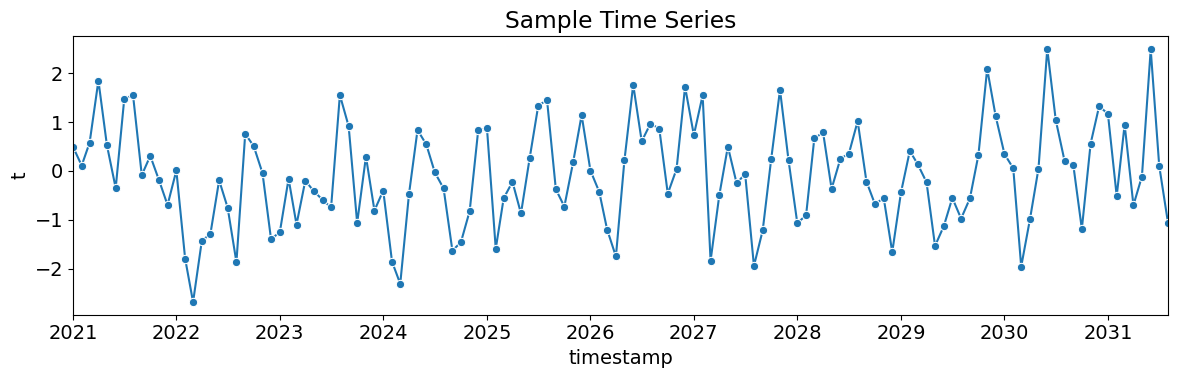

In [15]:
np.random.seed(SEED)
ar = np.r_[1] # add zero-lag and negate
ma = np.r_[1, np.array([beta_1])] # add zero-lag

sample = pd.DataFrame({'timestamp' : pd.date_range('2021-01-01', periods=num_samples, freq='MS'),
                       't' : sm.tsa.arima_process.arma_generate_sample(ar, ma, num_samples)
                      })

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))

sns.lineplot(x=sample.timestamp, y=sample['t'], marker='o')
ax.set_xlim([sample.timestamp.iloc[0], sample.timestamp.iloc[-1]])
ax.set_title('Sample Time Series')
plt.tight_layout()
plt.show()

### 1. Check Stationarity
The sample data is stationary. Therefore, we do not need to difference the time series.

In [16]:
check_stationarity(sample['t'])

ADF Statistic: -7.933570
p-value: 0.000000
Critical Values:
	1%: -3.483
	5%: -2.885
	10%: -2.579
Stationary


### 2. Check ACF and PACF

We can make the following observations:
- There are several autocorrelations that are significantly non-zero. Therefore, the time series is non-random.
- High degree of autocorrelation between adjacent (lag = 1)

| | AR($p$) | MA($q$) | ARMA($p$, $q$) |
|-|-|-|-|
|ACF|Tails off (Geometric decay) | <span style= 'background:yellow'> Significant at lag $q$ / Cuts off after lag $q$  </span> |Tails off (Geometric decay) |
|PACF| Significant at each lag $p$ / Cuts off after lag $p$ |Tails off (Geometric decay) |Tails off (Geometric decay) |

-> We can use an **MA(1) model** to model this process.

So that for MA(1), we would model the MA(q) formula
$\hat{y}_t = \epsilon_t + \beta_1 \epsilon_{t-1} + \dots + \beta_{q} \epsilon_{t-q}$
to the following:

$\hat{y}_t = \epsilon_t + \beta_1 \epsilon_{t-1}$


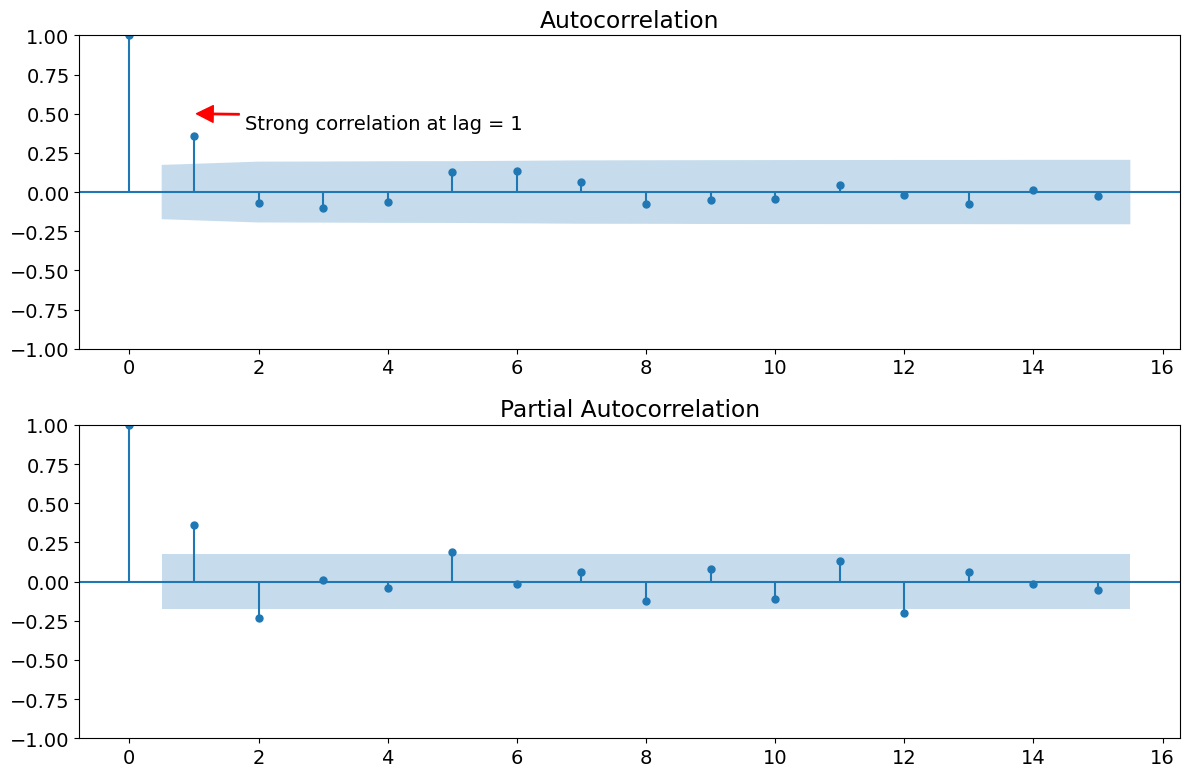

In [17]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(width, 2*height))
plot_acf(sample['t'],lags=lag_acf, ax=ax[0])
plot_pacf(sample['t'],lags=lag_pacf, ax=ax[1], method='ols')

ax[0].annotate('Strong correlation at lag = 1', xy=(1, 0.5),  xycoords='data',
            xytext=(0.15, 0.7), textcoords='axes fraction',
            arrowprops=dict(color='red', shrink=0.05, width=1))

plt.tight_layout()
plt.show()

### 3. Modelling

In [20]:
train = sample['t'][:train_len]
ma_model = ARMA(train, order=(0,1)).fit()

print(ma_model.summary())
pred = ma_model.predict(start=train_len, end=num_samples, dynamic=False)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
sns.lineplot(x=sample.timestamp[train_len:num_samples], y=sample.t[train_len:num_samples], marker='o', label='test', color='grey')
sns.lineplot(x=sample.timestamp[:train_len], y=train, marker='o', label='train')
sns.lineplot(x=sample.timestamp[train_len:num_samples], y=pred, marker='o', label='pred')
ax.set_xlim([sample.timestamp.iloc[0], sample.timestamp.iloc[-1]])
ax.set_title('Sample Time Series')
plt.tight_layout()
plt.show()

NotImplementedError: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been removed in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and statsmodels.tsa.SARIMAX.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained. It also offers alternative specialized
parameter estimators.


As you can see, the MA(1) model fits $\beta_1 = 0.5172$, which is quite close to the `beta_1 = 0.5`. However, the predicted values seem to be quite off as well in this case - similarly to the AR(p) cases.

## MA(2) Process
The following time series is an MA(2) process with 128 timesteps and the following parameters:

In [21]:
beta_1 = 0.5
beta_2 = 0.5

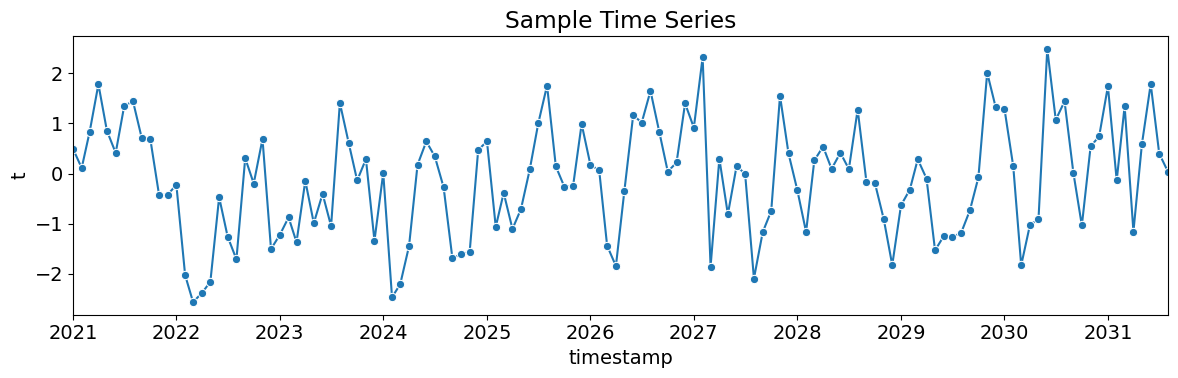

In [22]:
np.random.seed(SEED)
ar = np.r_[1] # add zero-lag and negate
ma = np.r_[1, np.array([beta_1, beta_2])] # add zero-lag

sample = pd.DataFrame({'timestamp' : pd.date_range('2021-01-01', periods=num_samples, freq='MS'),
                       't' : sm.tsa.arima_process.arma_generate_sample(ar, ma, num_samples)
                      })

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))

sns.lineplot(x=sample.timestamp, y=sample['t'], marker='o')
ax.set_xlim([sample.timestamp.iloc[0], sample.timestamp.iloc[-1]])
ax.set_title('Sample Time Series')
plt.tight_layout()
plt.show()

### 1. Check Stationarity
The sample data is stationary. Therefore, we do not need to difference the time series.

In [23]:
check_stationarity(sample['t'])

ADF Statistic: -3.882572
p-value: 0.002167
Critical Values:
	1%: -3.485
	5%: -2.886
	10%: -2.580
Stationary


### 2. Check ACF and PACF

We can make the following observations:
- There are several autocorrelations that are significantly non-zero. Therefore, the time series is non-random.
- High degree of autocorrelation between adjacent (lag = 1) and near-adjacent (lag = 2) observations

| | AR($p$) | MA($q$) | ARMA($p$, $q$) |
|-|-|-|-|
|ACF|Tails off (Geometric decay) | <span style= 'background:yellow'> Significant at lag $q$ / Cuts off after lag $q$  </span> |Tails off (Geometric decay) |
|PACF| Significant at each lag $p$ / Cuts off after lag $p$ |Tails off (Geometric decay) |Tails off (Geometric decay) |

-> We can use an **MA(2) model** to model this process.

So that for MA(2), we would model the MA(q) formula
$\hat{y}_t = \epsilon_t + \beta_1 \epsilon_{t-1} + \dots + \beta_{q} \epsilon_{t-q}$
to the following:

$\hat{y}_t = \epsilon_t + \beta_1 \epsilon_{t-1} + \beta_2 \epsilon_{t-2}$

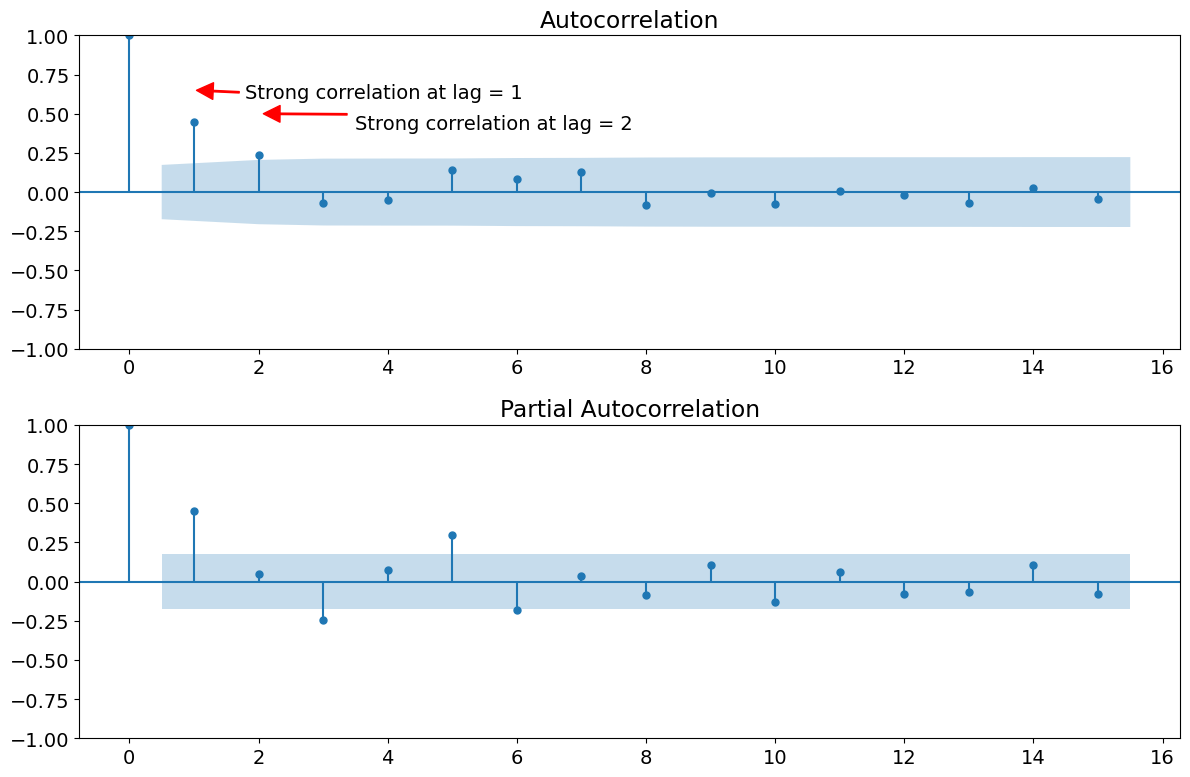

In [24]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(width, 2*height))
plot_acf(sample['t'],lags=lag_acf, ax=ax[0])
plot_pacf(sample['t'],lags=lag_pacf, ax=ax[1], method='ols')

ax[0].annotate('Strong correlation at lag = 1', xy=(1, 0.65),  xycoords='data',
            xytext=(0.15, 0.8), textcoords='axes fraction',
            arrowprops=dict(color='red', shrink=0.05, width=1))

ax[0].annotate('Strong correlation at lag = 2', xy=(2, 0.5),  xycoords='data',
            xytext=(0.25, 0.7), textcoords='axes fraction',
            arrowprops=dict(color='red', shrink=0.05, width=1))

plt.tight_layout()
plt.show()

### 3. Modelling

In [25]:
train = sample['t'][:train_len]
ma_model = ARMA(train, order=(0,2)).fit()

print(ma_model.summary())
pred = ma_model.predict(start=train_len, end=num_samples, dynamic=False)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
sns.lineplot(x=sample.timestamp[train_len:num_samples], y=sample.t[train_len:num_samples], marker='o', label='test', color='grey')
sns.lineplot(x=sample.timestamp[:train_len], y=train, marker='o', label='train')
sns.lineplot(x=sample.timestamp[train_len:num_samples], y=pred, marker='o', label='pred')
ax.set_xlim([sample.timestamp.iloc[0], sample.timestamp.iloc[-1]])
ax.set_title('Sample Time Series')
plt.tight_layout()
plt.show()

NotImplementedError: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been removed in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and statsmodels.tsa.SARIMAX.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained. It also offers alternative specialized
parameter estimators.


As you can see, the MA(2) model fits $\beta_1 = 0.5226$ and $\beta_2 = -0.5843$, which is quite close to the `beta_1 = 0.5` and `beta_2 = 0.5` which we have set. However, the predicted values seem to be quite off as well in this case - similarly to the MA(1) case.

## Periodical
The following time series is periodical with T=12. It consists of 48 timesteps.

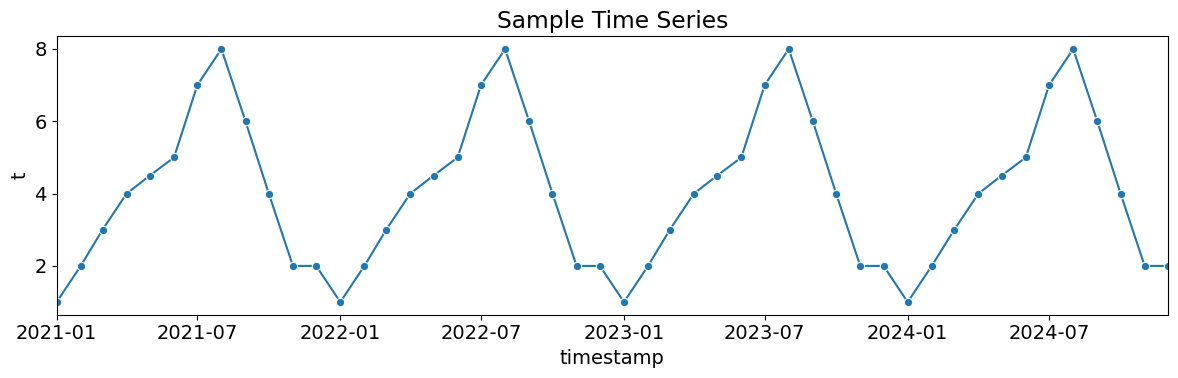

In [26]:
T = 12

sample = pd.DataFrame({'timestamp' : pd.date_range('2021-01-01', periods=48, freq='MS'),
                       't' : [1, 2, 3, 4, 4.5, 5, 7, 8, 6, 4, 2, 2, 1, 2, 3, 4, 4.5, 5, 7, 8, 6, 4, 2, 2, 1, 2, 3, 4, 4.5, 5, 7, 8, 6, 4, 2, 2, 1, 2, 3, 4, 4.5, 5, 7, 8, 6, 4, 2, 2]
                      })

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))

sns.lineplot(x=sample.timestamp, y=sample['t'], marker='o')
ax.set_xlim([sample.timestamp.iloc[0], sample.timestamp.iloc[-1]])
ax.set_title('Sample Time Series')
plt.tight_layout()
plt.show()

### 1. Check Stationarity
The sample data is stationary. Therefore, we do not need to difference the time series.

In [27]:
check_stationarity(sample['t'])

ADF Statistic: -24886124212233.375000
p-value: 0.000000
Critical Values:
	1%: -3.621
	5%: -2.944
	10%: -2.610
Stationary


### 2. Check ACF and PACF

We can make the following observations:
- There are several autocorrelations that are significantly non-zero. Therefore, the time series is non-random.
- High degree of autocorrelation between adjacent (lag = 1) and near-adjacent observations
- From both the ACF and PACF plot, we can see a strong correlation with the adjacent observation (lag = 1) and also at a lag of 12, which is the amount of T.


| | AR($p$) | MA($q$) | ARMA($p$, $q$) |
|-|-|-|-|
|ACF|Tails off (Geometric decay) |Significant at lag $q$ / Cuts off after lag $q$  |Tails off (Geometric decay) |
|PACF| <span style= 'background:yellow'> Significant at each lag $p$ / Cuts off after lag $p=12$ </span>|Tails off (Geometric decay) |Tails off (Geometric decay) |

-> We can use an AR(12) model to model this process.

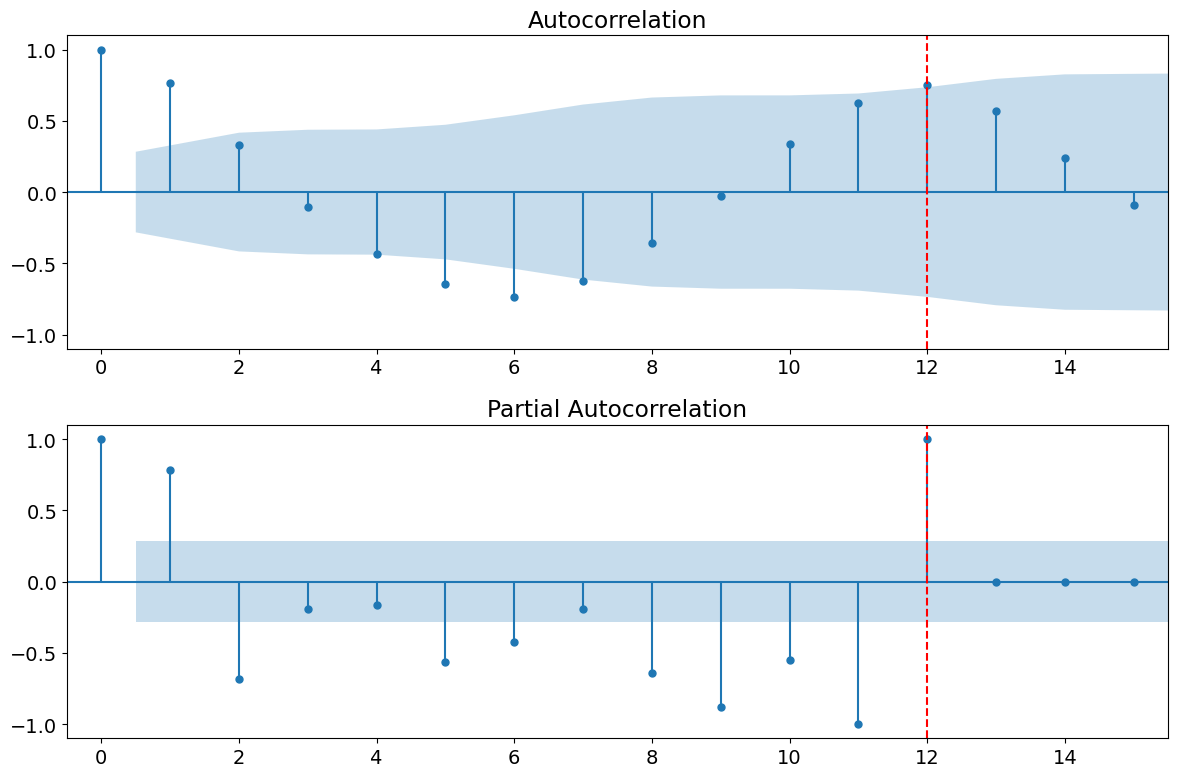

In [28]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(width, 2*height))
plot_acf(sample['t'],lags=lag_acf, ax=ax[0])
plot_pacf(sample['t'],lags=lag_pacf, ax=ax[1], method='ols')

for i in range(2):
    ax[i].axvline(x=T, color='r', linestyle='--')
    ax[i].set_xlim([-0.5, lag_acf+0.5])
    ax[i].set_ylim([-1.1, 1.1])
    
plt.tight_layout()
plt.show()

### 3. Modelling

In [29]:
train = sample['t'][:26]
ar_model = AutoReg(train, lags=12).fit()

print(ar_model.summary())
pred = ar_model.predict(start=26, end=48, dynamic=False)

                            AutoReg Model Results                             
Dep. Variable:                      t   No. Observations:                   26
Model:                    AutoReg(12)   Log Likelihood                 434.691
Method:               Conditional MLE   S.D. of innovations              0.000
Date:                Mon, 10 Jul 2023   AIC                           -841.383
Time:                        10:00:49   BIC                           -832.436
Sample:                            12   HQIC                          -842.211
                                   26                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0205   7.86e-18   2.61e+15      0.000       0.021       0.021
t.L1          -0.0004   4.89e-15  -8.64e+10      0.000      -0.000      -0.000
t.L2          -0.0004   5.02e-15  -8.43e+10      0.0

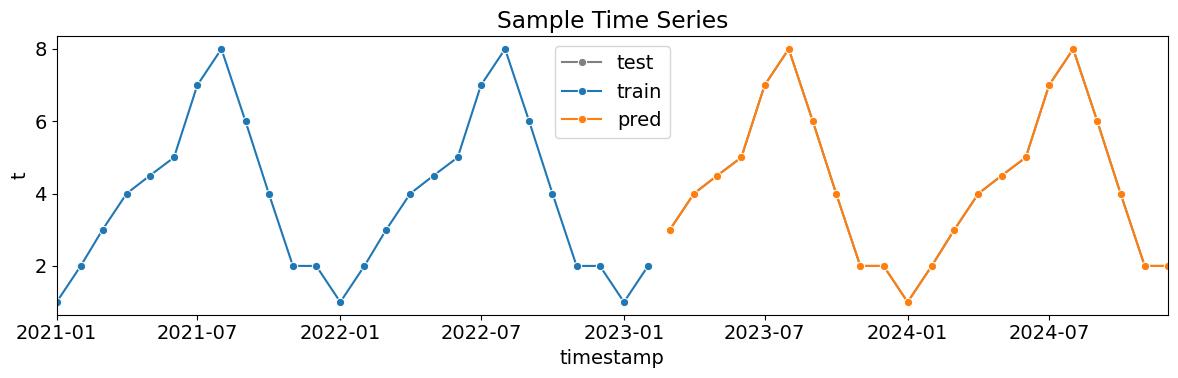

In [30]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
sns.lineplot(x=sample.timestamp[26:48], y=sample.t[26:48], marker='o', label='test', color='grey')
sns.lineplot(x=sample.timestamp[:26], y=train, marker='o', label='train')
sns.lineplot(x=sample.timestamp[26:48], y=pred, marker='o', label='pred')
ax.set_xlim([sample.timestamp.iloc[0], sample.timestamp.iloc[-1]])
ax.set_title('Sample Time Series')
plt.tight_layout()
plt.show()

As you can see, the AR(12) model fits the periodical time series perfectly with $\alpha_{1...11} = -0.0004$ and $\alpha_12 = 0.9996$. 

The model $\hat{y}_t = \alpha_1 y_{t-1} + \dots + {\alpha_p}y_{t-p}$ with $p=12$ results in:
$\hat{y}_t = \alpha_1 y_{t-1} + \alpha_2 y_{t-2} + \alpha_3 y_{t-3} + \alpha_4 y_{t-4} + \alpha_5 y_{t-5} + \alpha_6 y_{t-6} + \alpha_7 y_{t-7} + \alpha_8 y_{t-8} + \alpha_9 y_{t-9} + \alpha_{10} y_{t-10} + \alpha_{11} y_{t-11} + {\alpha_{12}}y_{t-12}$

And with the coefficients $\alpha_{1...11} = -0.0004 \approx 0 $ and $\alpha_{12} = 0.9996 \approx 1$, we get:

$\hat{y}_t = y_{t-12}$

## Trend

The following time series is the same as [Periodical](#Periodical) (periodical with T=12) with added trend. It consists of 48 timesteps.

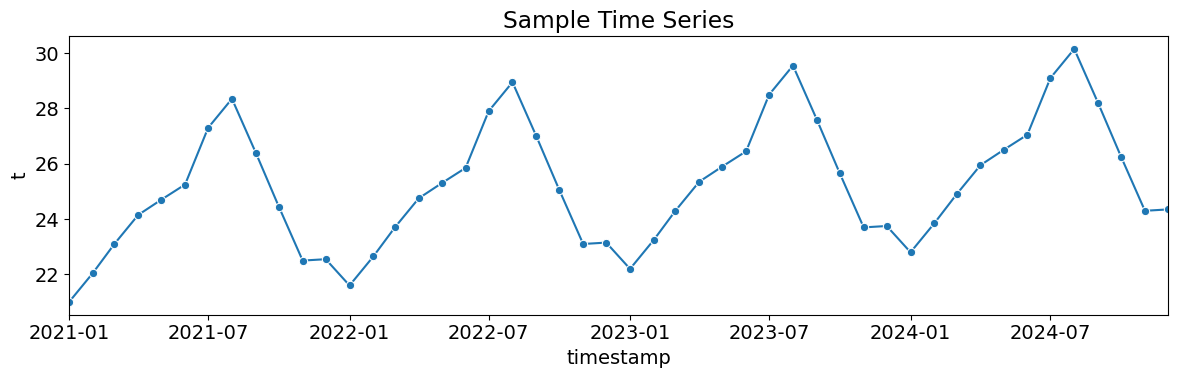

In [31]:
time = np.arange(0, 48)
sample = pd.DataFrame({'timestamp' : pd.date_range('2021-01-01', periods=48, freq='MS'),
                       't' : [1, 2, 3, 4, 4.5, 5, 7, 8, 6, 4, 2, 2, 1, 2, 3, 4, 4.5, 5, 7, 8, 6, 4, 2, 2, 1, 2, 3, 4, 4.5, 5, 7, 8, 6, 4, 2, 2, 1, 2, 3, 4, 4.5, 5, 7, 8, 6, 4, 2, 2] + ((0.05*time)+20)
                      })

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))

sns.lineplot(x=sample.timestamp, y=sample['t'], marker='o')
ax.set_xlim([sample.timestamp.iloc[0], sample.timestamp.iloc[-1]])
ax.set_title('Sample Time Series')
plt.tight_layout()
plt.show()

### 1. Check Stationarity
The sample data is non-stationary. 

In [32]:
check_stationarity(sample['t'])

ADF Statistic: -0.117684
p-value: 0.947648
Critical Values:
	1%: -3.621
	5%: -2.944
	10%: -2.610
Non-stationary


Therefore, we need to difference the time series.

In [33]:
sample['t_diff'] = sample['t'].diff().fillna(0)

display(sample.head(5).style.set_caption('Sample Time Series'))

check_stationarity(sample['t_diff'])

,timestamp,t,t_diff
0,2021-01-01 00:00:00,21.000000,0.000000
1,2021-02-01 00:00:00,22.050000,1.050000
2,2021-03-01 00:00:00,23.100000,1.050000
3,2021-04-01 00:00:00,24.150000,1.050000
4,2021-05-01 00:00:00,24.700000,0.550000


ADF Statistic: -21.691240
p-value: 0.000000
Critical Values:
	1%: -3.621
	5%: -2.944
	10%: -2.610
Stationary


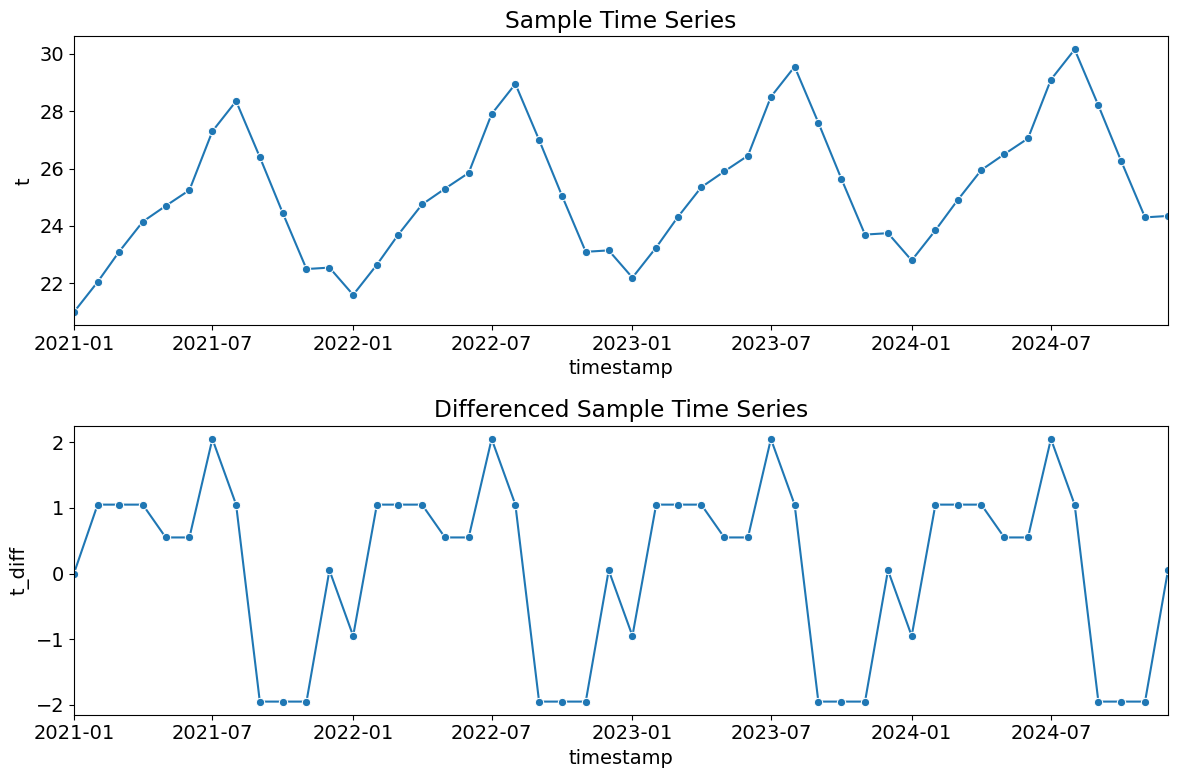

In [34]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))

sns.lineplot(x=sample.timestamp, y=sample['t'], marker='o', ax=ax[0])
ax[0].set_xlim([sample.timestamp.iloc[0], sample.timestamp.iloc[-1]])

ax[0].set_title('Sample Time Series')

sns.lineplot(x=sample.timestamp, y=sample['t_diff'], marker='o', ax=ax[1])
ax[1].set_xlim([sample.timestamp.iloc[0], sample.timestamp.iloc[-1]])
ax[1].set_title('Differenced Sample Time Series')
plt.tight_layout()
plt.show()

### 2. Check ACF and PACF

We can make the following observations:
- There are several autocorrelations that are significantly non-zero. Therefore, the time series is non-random.
- High degree of autocorrelation between adjacent (lag = 1) and near-adjacent observations

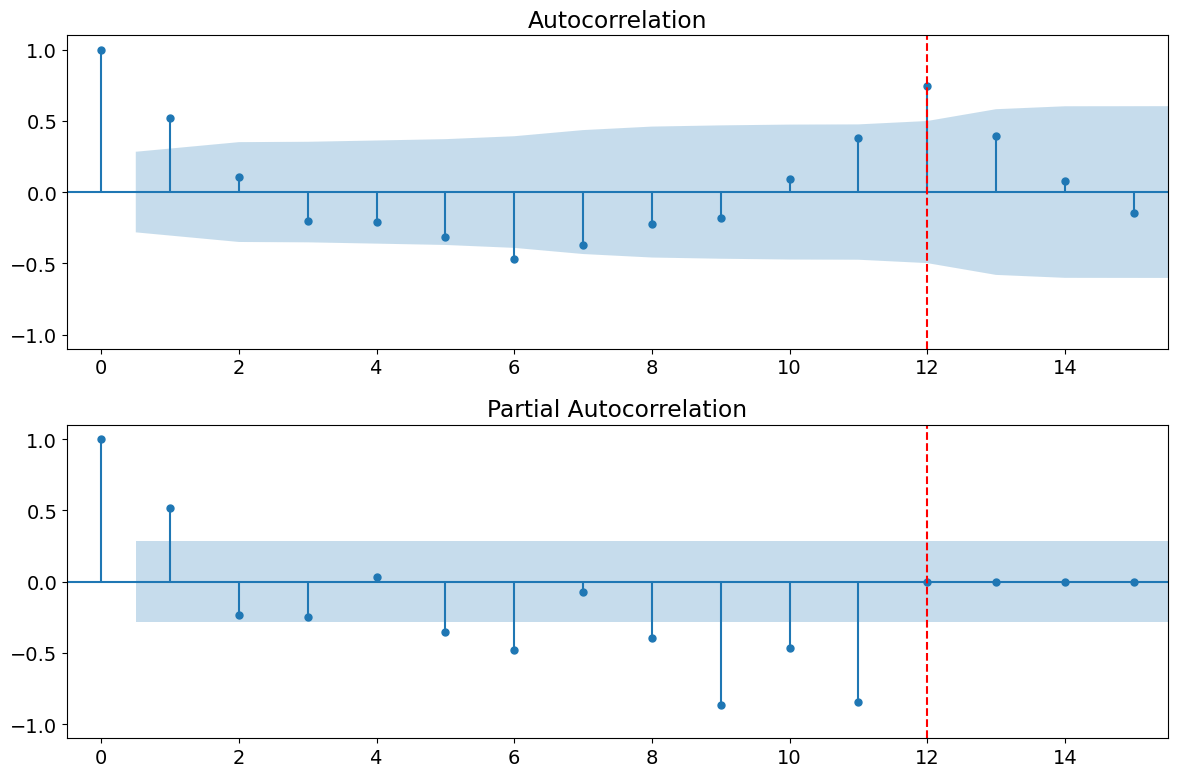

In [35]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(width, 2*height))
plot_acf(sample['t_diff'],lags=lag_acf, ax=ax[0])
plot_pacf(sample['t_diff'],lags=lag_pacf, ax=ax[1], method='ols')

for i in range(2):
    ax[i].axvline(x=T, color='r', linestyle='--')
    ax[i].set_xlim([-0.5, lag_acf+0.5])
    ax[i].set_ylim([-1.1, 1.1])
    
plt.tight_layout()
plt.show()

### 3. Modelling

## White Noise

The following time series is random. It consists of 48 timesteps.

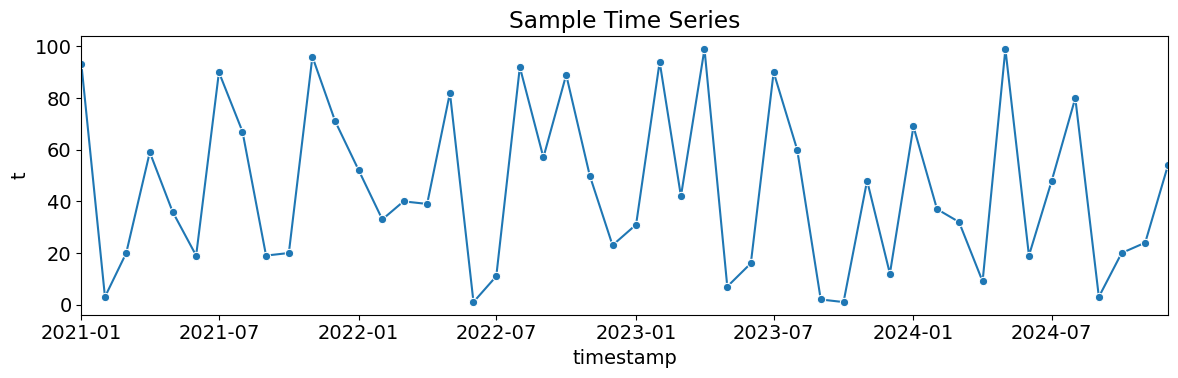

In [36]:
sample = pd.DataFrame({'timestamp' : pd.date_range('2021-01-01', periods=48, freq='MS'),
                       't' : np.random.randint(1,101,len(time))
                      })

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))

sns.lineplot(x=sample.timestamp, y=sample['t'], marker='o')
ax.set_xlim([sample.timestamp.iloc[0], sample.timestamp.iloc[-1]])
ax.set_title('Sample Time Series')
plt.tight_layout()
plt.show()

### 1. Check Stationarity
The sample data is stationary. Therefore, we do not need to difference the time series.

In [37]:
check_stationarity(sample['t'])

ADF Statistic: -7.978782
p-value: 0.000000
Critical Values:
	1%: -3.578
	5%: -2.925
	10%: -2.601
Stationary


### 2. Check ACF and PACF

We can make the following observations:
- There is only one autocorrelation that is significantly non-zero at a lag of 0. Therefore, the time series is random.

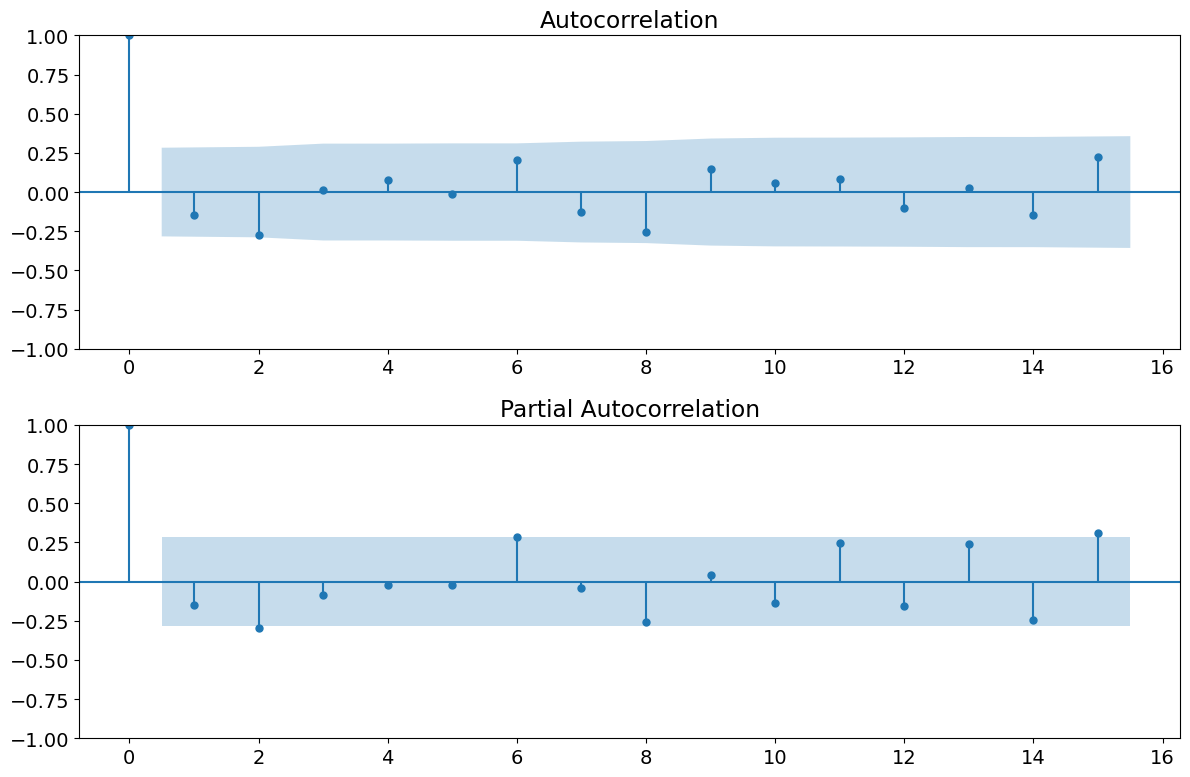

In [38]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(width, 2*height))
plot_acf(sample['t'],lags=lag_acf, ax=ax[0])
plot_pacf(sample['t'],lags=lag_pacf, ax=ax[1], method='ols')
    
plt.tight_layout()
plt.show()

### 3. Modelling

Modelling white noise is difficult because we cannot retrieve any parameters from the ACF and PACF plots.

## Random-Walk

The following time series is random like [White Noise](#White-Noise). However, the current value depends on the previous one. It consists of 48 timesteps.

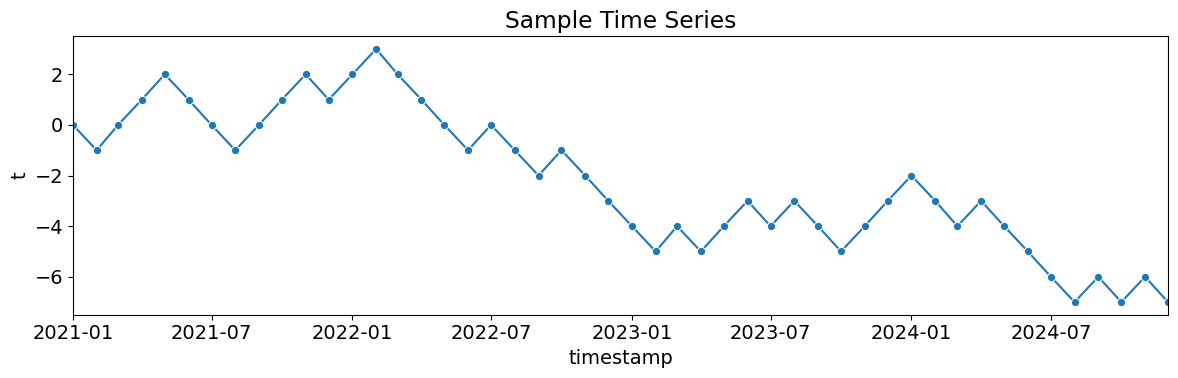

In [39]:
# Copied from https://towardsdatascience.com/time-series-from-scratch-white-noise-and-random-walk-5c96270514d3
# Start with a random number - let's say 0
np.random.seed(42)

random_walk = [0]

for i in range(1, 48):
    # Movement direction based on a random number
    num = -1 if np.random.random() < 0.5 else 1
    random_walk.append(random_walk[-1] + num)
    
sample = pd.DataFrame({'timestamp' : pd.date_range('2021-01-01', periods=48, freq='MS'),
                       't' : random_walk
                      })

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))

sns.lineplot(x=sample.timestamp, y=sample['t'], marker='o')
ax.set_xlim([sample.timestamp.iloc[0], sample.timestamp.iloc[-1]])
ax.set_title('Sample Time Series')
plt.tight_layout()
plt.show()

### 1. Check Stationarity
The sample data is non-stationary. Therefore, we need to difference the time series.

In [40]:
check_stationarity(sample['t'])

ADF Statistic: -0.731503
p-value: 0.838420
Critical Values:
	1%: -3.578
	5%: -2.925
	10%: -2.601
Non-stationary


In [41]:
sample['t_diff'] = sample['t'].diff().fillna(0)

check_stationarity(sample['t_diff'])

ADF Statistic: -3.047661
p-value: 0.030677
Critical Values:
	1%: -3.597
	5%: -2.933
	10%: -2.605
Stationary


### 2. Check ACF and PACF

We can make the following observations:
- In contrast to the ACF and PACF of the [White Noise](#White-Noise) process, we can see that for a lag of 1, we have some light correlation because the current value depends on the previous one.

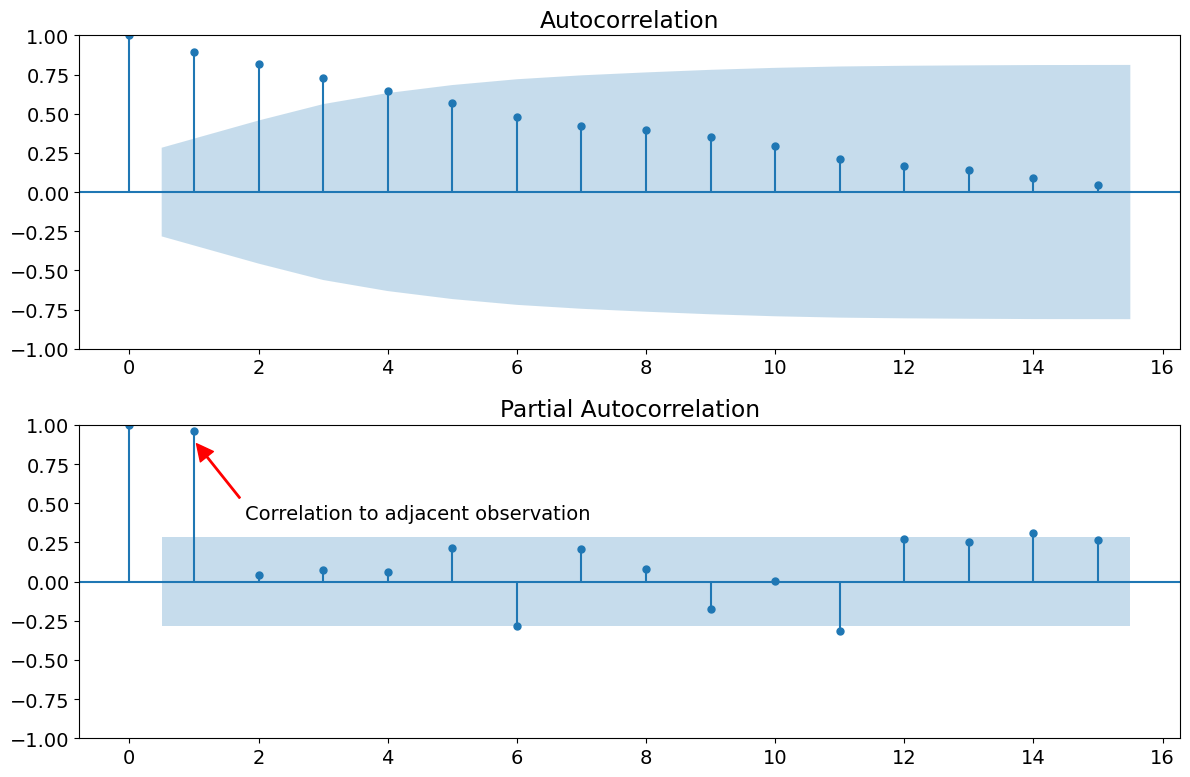

In [42]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(width, 2*height))
plot_acf(sample['t'],lags=lag_acf, ax=ax[0])
plot_pacf(sample['t'],lags=lag_pacf, ax=ax[1], method='ols')

ax[1].annotate('Correlation to adjacent observation', xy=(1, 0.9),  xycoords='data',
            xytext=(0.15, 0.7), textcoords='axes fraction',
            arrowprops=dict(color='red', shrink=0.05, width=1))
plt.tight_layout()
plt.show()

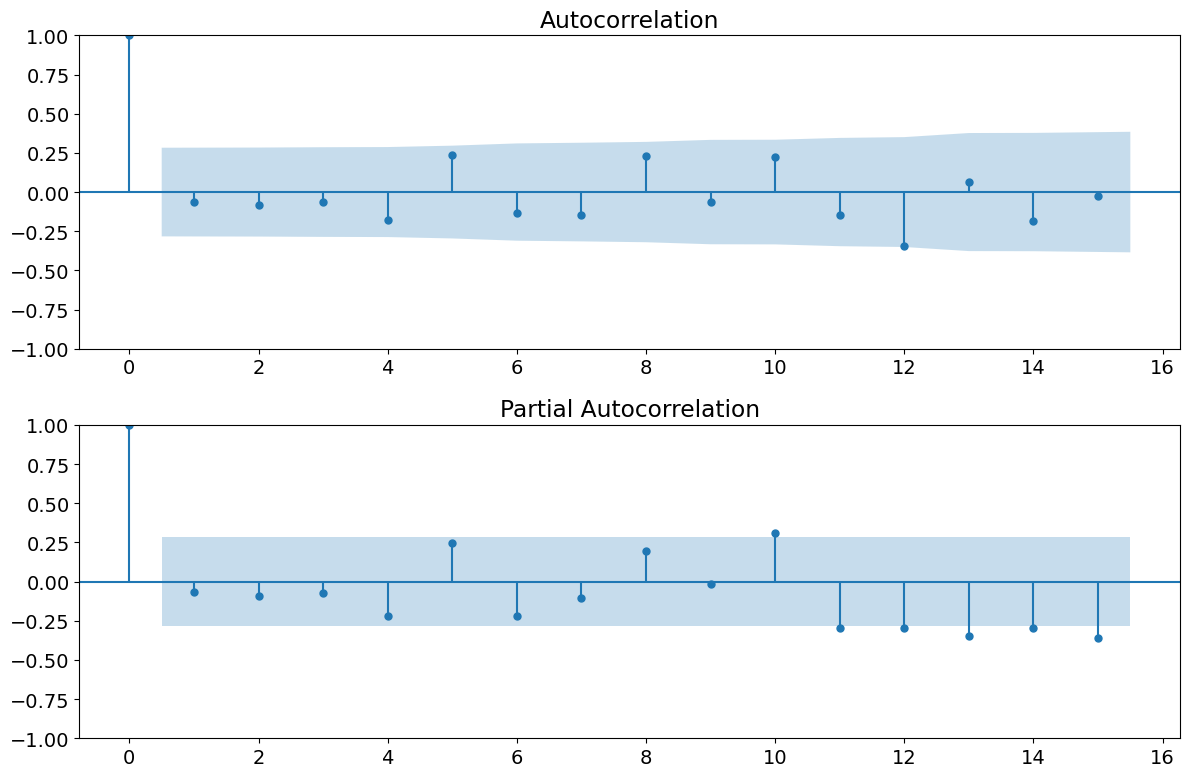

In [43]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(width, 2*height))
plot_acf(sample['t_diff'],lags=lag_acf, ax=ax[0])
plot_pacf(sample['t_diff'],lags=lag_pacf, ax=ax[1], method='ols')
plt.tight_layout()
plt.show()

### 3. Modelling

Similarly to white noise, modelling random-walk is difficult because we cannot retrieve any parameters from the ACF and PACF plots.

## Constant

The following time series is constant. It consists of 48 timesteps.

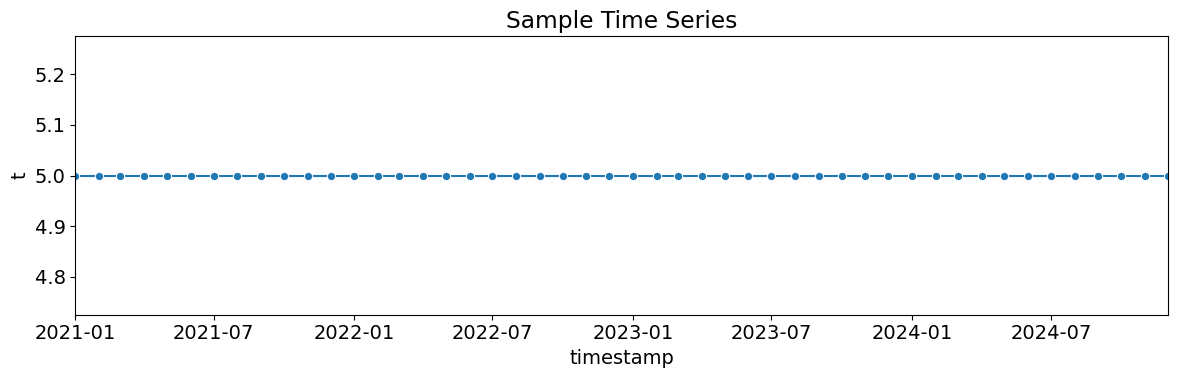

In [44]:
sample = pd.DataFrame({'timestamp' : pd.date_range('2021-01-01', periods=48, freq='MS'),
                       't' : 5
                      })

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))

sns.lineplot(x=sample.timestamp, y=sample['t'], marker='o')
ax.set_xlim([sample.timestamp.iloc[0], sample.timestamp.iloc[-1]])
ax.set_title('Sample Time Series')
plt.tight_layout()
plt.show()

### 1. Check Stationarity
The sample data is non-stationary. Therefore, we need to difference the time series.

In [45]:
check_stationarity(sample['t'])

ADF Statistic: nan
p-value: nan
Critical Values:
	1%: -3.578
	5%: -2.925
	10%: -2.601
Non-stationary


In [46]:
sample['t_diff'] = sample['t'].diff().fillna(0)

check_stationarity(sample['t_diff'])

ADF Statistic: nan
p-value: nan
Critical Values:
	1%: -3.578
	5%: -2.925
	10%: -2.601
Non-stationary


### 2. Check ACF and PACF

- ACF/PACF was applied to non-stationary time series

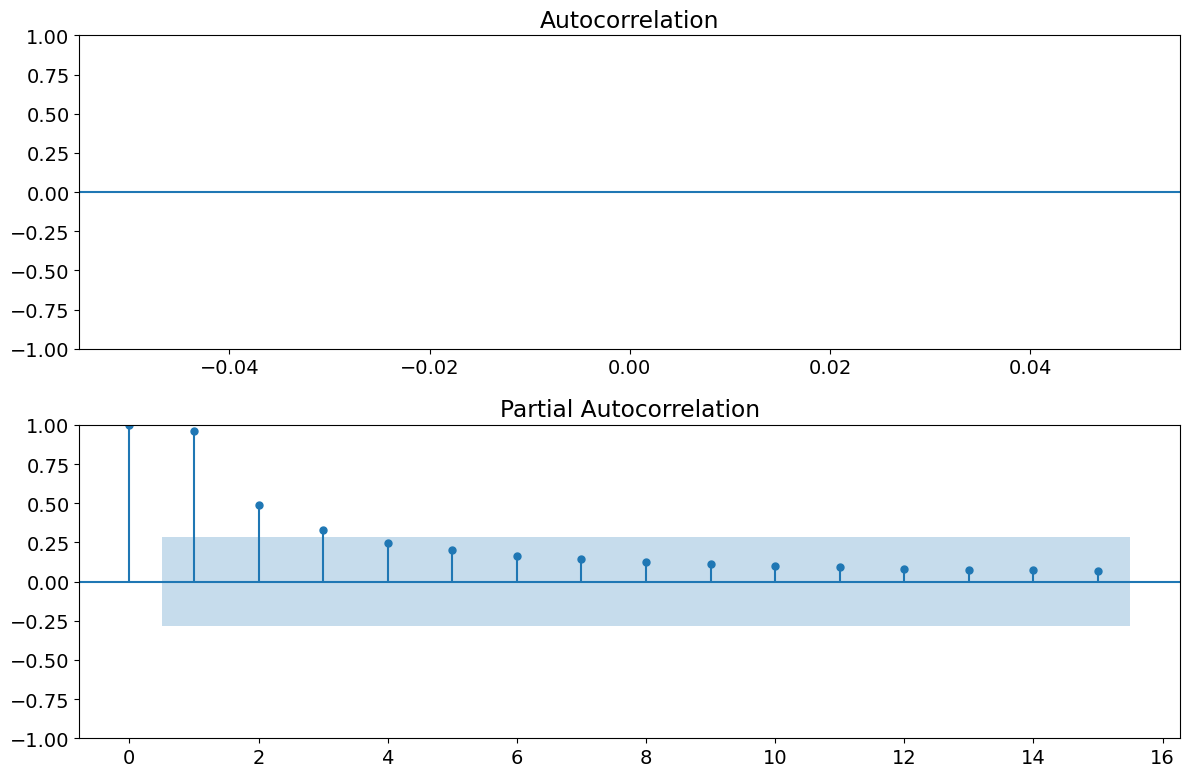

In [47]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(width, 2*height))
plot_acf(sample['t'],lags=lag_acf, ax=ax[0])
plot_pacf(sample['t'],lags=lag_pacf, ax=ax[1], method='ols')
    
plt.tight_layout()
plt.show()

### 3. Modelling

Modelling a constant as an AR or MA process is diffucult because we cannot retrieve any parameters from the ACF and PACF plots. But on the other hand, if you can retrieve that a time series is constant, it should not be too difficult to forecast it, right?

# 🚀 Cheat Sheet

1. Check stationarity. If stationary, continue to step 2. Else use differencing until time series is stationary and then continue to step 2.
2. Check ACF and PACF with following table
| | AR($p$) | MA($q$) | ARMA($p$, $q$) |
|-|-|-|-|
|ACF|Tails off (Geometric decay) | Significant at lag $q$ / Cuts off after lag $q$|Tails off (Geometric decay) |
|PACF| Significant at each lag $p$ / Cuts off after lag $p$|Tails off (Geometric decay) |Tails off (Geometric decay) |

3. Modelling

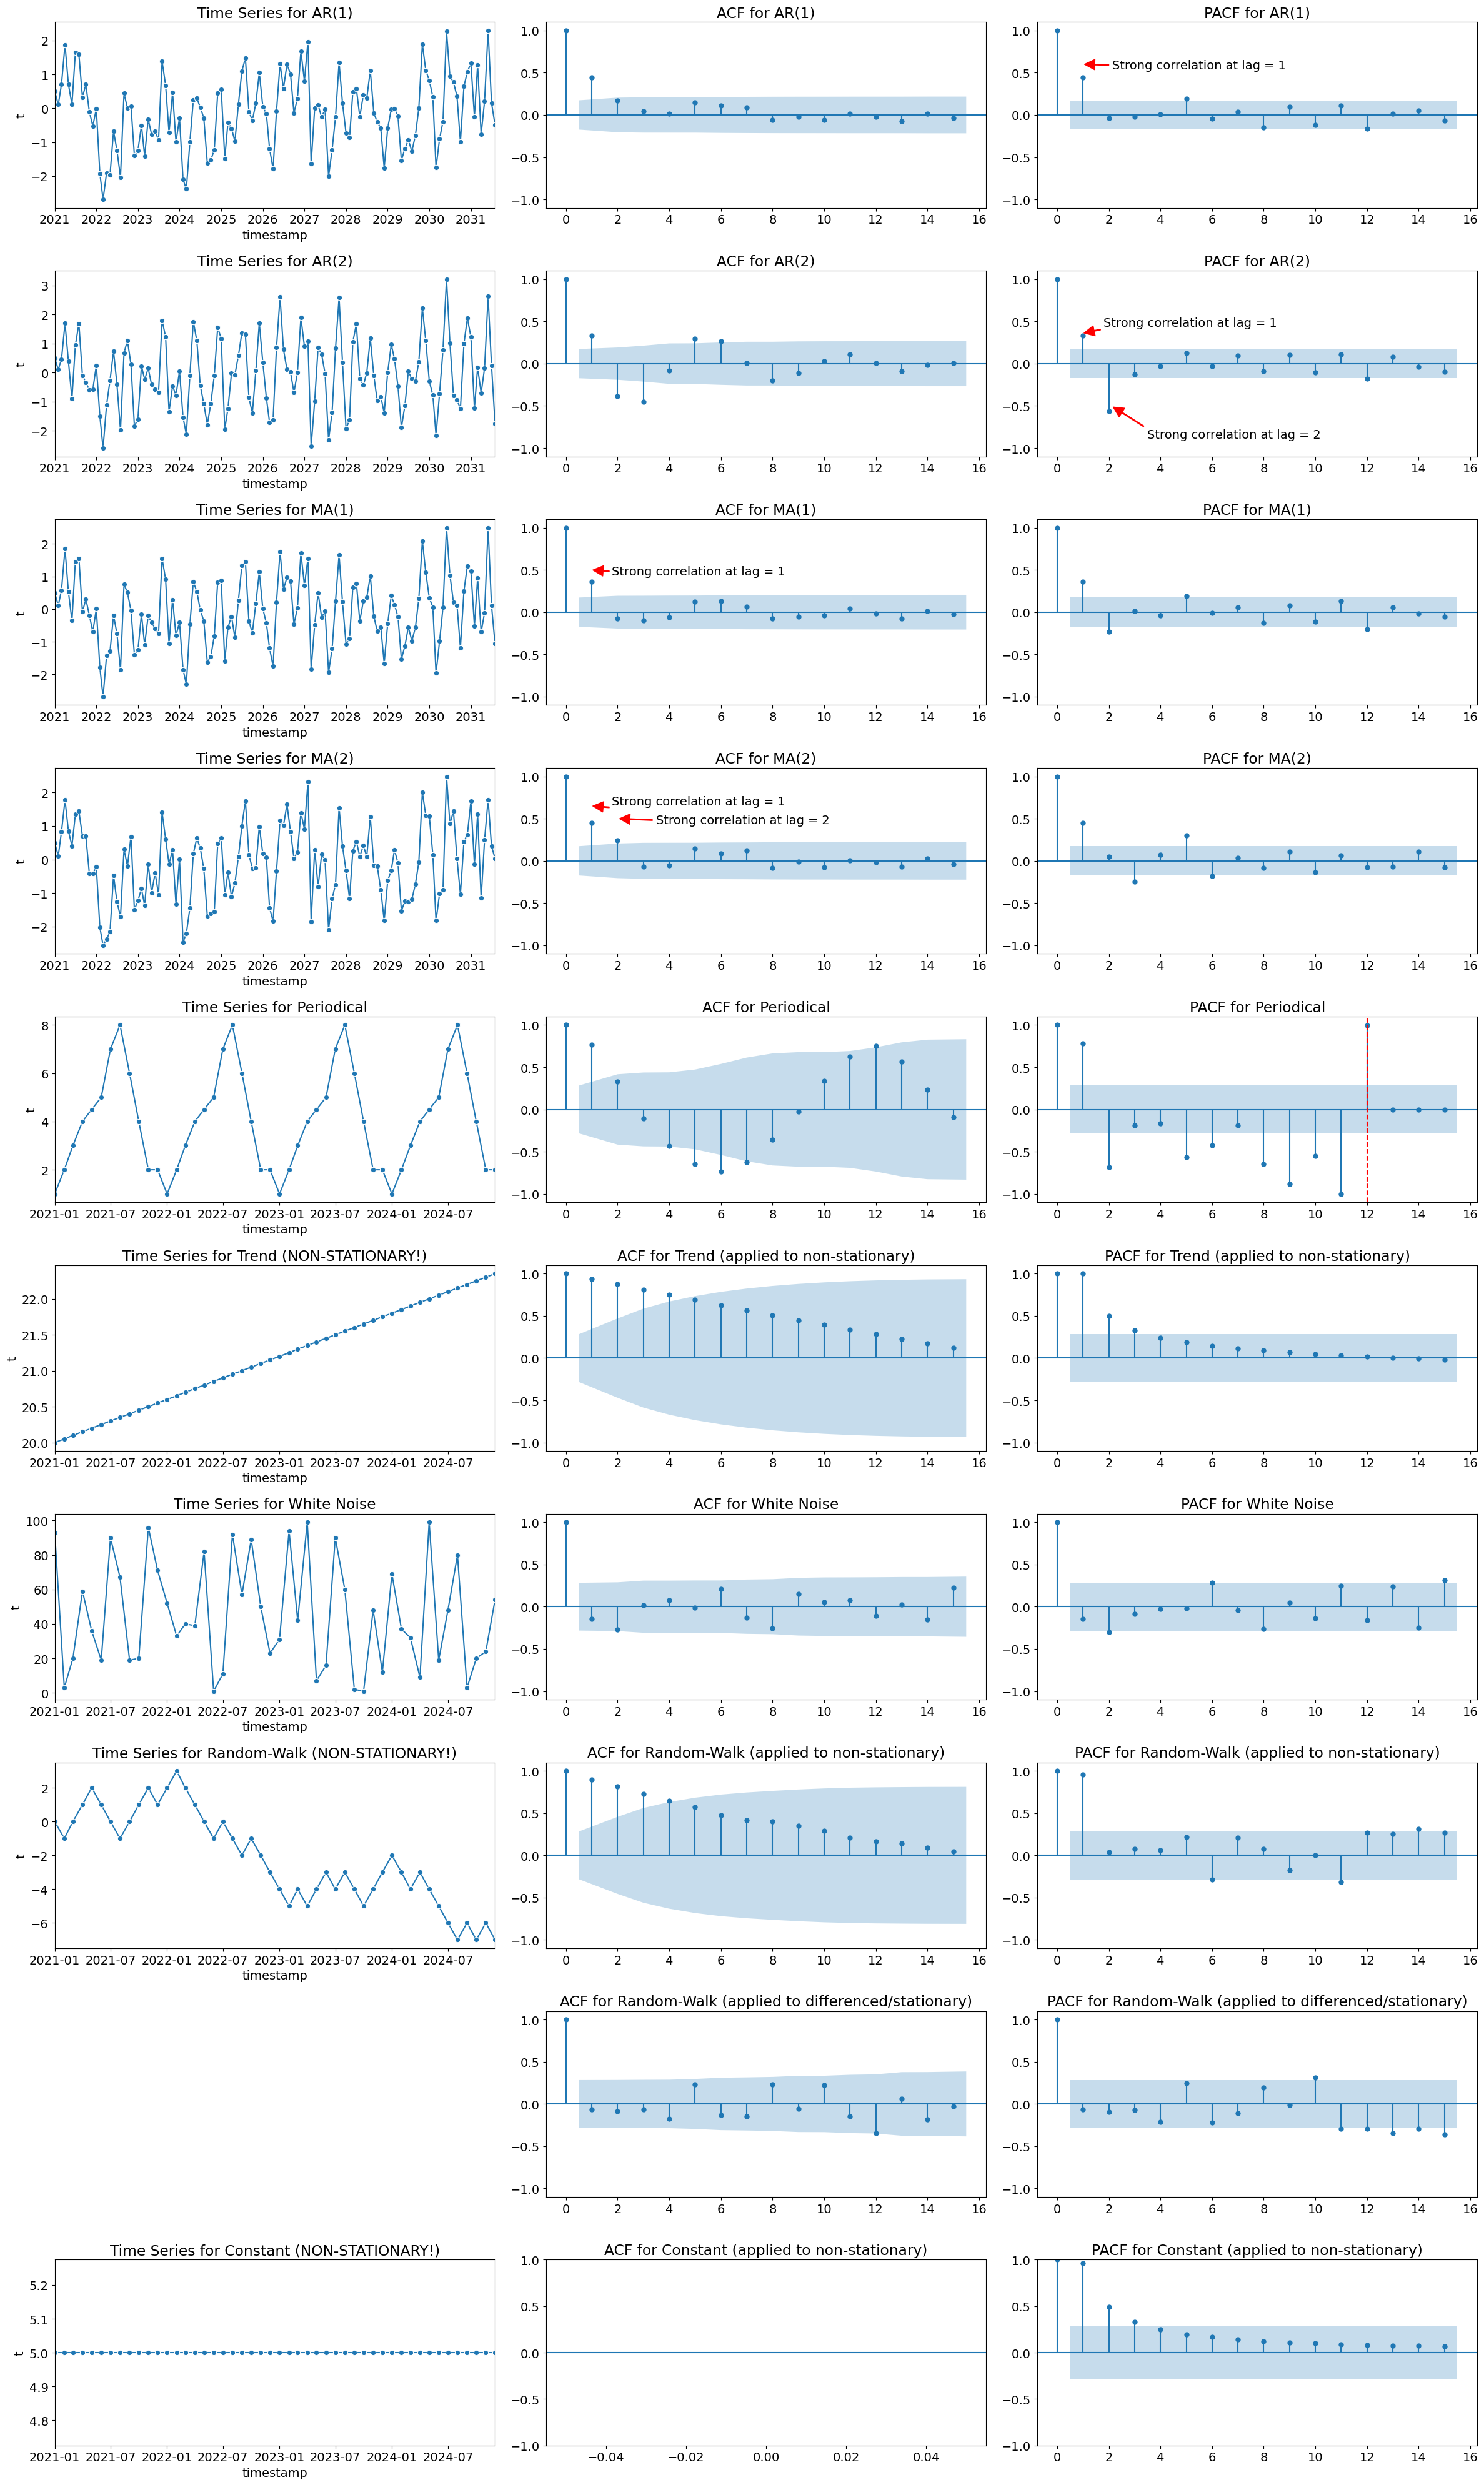

In [48]:
f, ax = plt.subplots(nrows=10, ncols=3, figsize=(2*width, 10*height))

### AR(1) ###
np.random.seed(SEED)
ar = np.r_[1, -np.array([alpha_1])] # add zero-lag and negate
ma = np.r_[1] # add zero-lag

sample = pd.DataFrame({'timestamp' : pd.date_range('2021-01-01', periods=num_samples, freq='MS'),
                       't' : sm.tsa.arima_process.arma_generate_sample(ar, ma, num_samples)
                      })

sns.lineplot(x=sample.timestamp, y=sample['t'], marker='o', ax=ax[0,0])
ax[0,0].set_xlim([sample.timestamp.iloc[0], sample.timestamp.iloc[-1]])
ax[0,0].set_title('Time Series for AR(1)')

plot_acf(sample['t'],lags=lag_acf, ax=ax[0, 1], title='ACF for AR(1)')
plot_pacf(sample['t'],lags=lag_pacf, ax=ax[0, 2], method='ols', title='PACF for AR(1)')
ax[0,2].annotate('Strong correlation at lag = 1', xy=(1, 0.6),  xycoords='data',
            xytext=(0.17, 0.75), textcoords='axes fraction',
            arrowprops=dict(color='red', shrink=0.05, width=1))

### AR(2) ###
np.random.seed(SEED)
ar = np.r_[1, -np.array([alpha_1, alpha_2])] # add zero-lag and negate
ma = np.r_[1] # add zero-lag

sample = pd.DataFrame({'timestamp' : pd.date_range('2021-01-01', periods=num_samples, freq='MS'),
                       't' : sm.tsa.arima_process.arma_generate_sample(ar, ma, num_samples)
                      })

sns.lineplot(x=sample.timestamp, y=sample['t'], marker='o', ax=ax[1,0])
ax[1,0].set_xlim([sample.timestamp.iloc[0], sample.timestamp.iloc[-1]])
ax[1,0].set_title('Time Series for AR(2)')

plot_acf(sample['t'],lags=lag_acf, ax=ax[1, 1], title='ACF for AR(2)')
plot_pacf(sample['t'],lags=lag_pacf, ax=ax[1, 2], method='ols', title='PACF for AR(2)')

ax[1, 2].annotate('Strong correlation at lag = 1', xy=(1, 0.36),  xycoords='data',
            xytext=(0.15, 0.7), textcoords='axes fraction',
            arrowprops=dict(color='red', shrink=0.05, width=1))

ax[1, 2].annotate('Strong correlation at lag = 2', xy=(2.1, -0.5),  xycoords='data',
            xytext=(0.25, 0.1), textcoords='axes fraction',
            arrowprops=dict(color='red', shrink=0.05, width=1))

### MA(1) ###
np.random.seed(SEED)
ar = np.r_[1] # add zero-lag and negate
ma = np.r_[1, np.array([beta_1])] # add zero-lag

sample = pd.DataFrame({'timestamp' : pd.date_range('2021-01-01', periods=num_samples, freq='MS'),
                       't' : sm.tsa.arima_process.arma_generate_sample(ar, ma, num_samples)
                      })    

sns.lineplot(x=sample.timestamp, y=sample['t'], marker='o', ax=ax[2,0])
ax[2,0].set_xlim([sample.timestamp.iloc[0], sample.timestamp.iloc[-1]])
ax[2,0].set_title('Time Series for MA(1)')

plot_acf(sample['t'],lags=lag_acf, ax=ax[2, 1], title='ACF for MA(1)')
plot_pacf(sample['t'],lags=lag_pacf, ax=ax[2, 2], method='ols', title='PACF for MA(1)')

ax[2,1].annotate('Strong correlation at lag = 1', xy=(1, 0.5),  xycoords='data',
            xytext=(0.15, 0.7), textcoords='axes fraction',
            arrowprops=dict(color='red', shrink=0.05, width=1))

### MA(2) ###
np.random.seed(SEED)
ar = np.r_[1] # add zero-lag and negate
ma = np.r_[1, np.array([beta_1, beta_2])] # add zero-lag

sample = pd.DataFrame({'timestamp' : pd.date_range('2021-01-01', periods=num_samples, freq='MS'),
                       't' : sm.tsa.arima_process.arma_generate_sample(ar, ma, num_samples)
                      })    

sns.lineplot(x=sample.timestamp, y=sample['t'], marker='o', ax=ax[3,0])
ax[3,0].set_xlim([sample.timestamp.iloc[0], sample.timestamp.iloc[-1]])
ax[3,0].set_title('Time Series for MA(2)')

plot_acf(sample['t'],lags=lag_acf, ax=ax[3, 1], title='ACF for MA(2)')
plot_pacf(sample['t'],lags=lag_pacf, ax=ax[3, 2], method='ols', title='PACF for MA(2)')

ax[3, 1].annotate('Strong correlation at lag = 1', xy=(1, 0.65),  xycoords='data',
            xytext=(0.15, 0.8), textcoords='axes fraction',
            arrowprops=dict(color='red', shrink=0.05, width=1))

ax[3, 1].annotate('Strong correlation at lag = 2', xy=(2, 0.5),  xycoords='data',
            xytext=(0.25, 0.7), textcoords='axes fraction',
            arrowprops=dict(color='red', shrink=0.05, width=1))

### Periodical ###
sample = pd.DataFrame({'timestamp' : pd.date_range('2021-01-01', periods=48, freq='MS'),
                       't' : [1, 2, 3, 4, 4.5, 5, 7, 8, 6, 4, 2, 2, 1, 2, 3, 4, 4.5, 5, 7, 8, 6, 4, 2, 2, 1, 2, 3, 4, 4.5, 5, 7, 8, 6, 4, 2, 2, 1, 2, 3, 4, 4.5, 5, 7, 8, 6, 4, 2, 2]
                      })

sns.lineplot(x=sample.timestamp, y=sample['t'], marker='o', ax=ax[4,0])
ax[4,0].set_xlim([sample.timestamp.iloc[0], sample.timestamp.iloc[-1]])
ax[4,0].set_title('Time Series for Periodical')

plot_acf(sample['t'],lags=lag_acf, ax=ax[4, 1], title='ACF for Periodical')
plot_pacf(sample['t'],lags=lag_pacf, ax=ax[4, 2], method='ols', title='PACF for Periodical')

ax[4,2].axvline(x=T, color='r', linestyle='--')

### Trend ###
sample = pd.DataFrame({'timestamp' : pd.date_range('2021-01-01', periods=48, freq='MS'),
                       't' : ((0.05*time)+20)
                      })

sns.lineplot(x=sample.timestamp, y=sample['t'], marker='o', ax=ax[5,0])
ax[5,0].set_xlim([sample.timestamp.iloc[0], sample.timestamp.iloc[-1]])
ax[5,0].set_title('Time Series for Trend (NON-STATIONARY!)')

plot_acf(sample['t'],lags=lag_acf, ax=ax[5, 1], title='ACF for Trend (applied to non-stationary)')
plot_pacf(sample['t'],lags=lag_pacf, ax=ax[5, 2], method='ols', title='PACF for Trend (applied to non-stationary)')

### White Noise ###
sample = pd.DataFrame({'timestamp' : pd.date_range('2021-01-01', periods=48, freq='MS'),
                       't' : np.random.randint(1,101,len(time))
                      })

sns.lineplot(x=sample.timestamp, y=sample['t'], marker='o', ax=ax[6,0])
ax[6,0].set_xlim([sample.timestamp.iloc[0], sample.timestamp.iloc[-1]])
ax[6,0].set_title('Time Series for White Noise')

plot_acf(sample['t'],lags=lag_acf, ax=ax[6, 1], title='ACF for White Noise')
plot_pacf(sample['t'],lags=lag_pacf, ax=ax[6, 2], method='ols', title='PACF for White Noise')

### Random-Walk ###
sample = pd.DataFrame({'timestamp' : pd.date_range('2021-01-01', periods=48, freq='MS'),
                       't' : random_walk
                      })

sns.lineplot(x=sample.timestamp, y=sample['t'], marker='o', ax=ax[7,0])
ax[7,0].set_xlim([sample.timestamp.iloc[0], sample.timestamp.iloc[-1]])
ax[7,0].set_title('Time Series for Random-Walk (NON-STATIONARY!)')

plot_acf(sample['t'],lags=lag_acf, ax=ax[7, 1], title='ACF for Random-Walk (applied to non-stationary)')
plot_pacf(sample['t'],lags=lag_pacf, ax=ax[7, 2], method='ols', title='PACF for Random-Walk (applied to non-stationary)')

sample['t_diff'] = sample['t'].diff().fillna(0)

plot_acf(sample['t_diff'],lags=lag_acf, ax=ax[8, 1], title='ACF for Random-Walk (applied to differenced/stationary)')
plot_pacf(sample['t_diff'],lags=lag_pacf, ax=ax[8, 2], method='ols', title='PACF for Random-Walk (applied to differenced/stationary)')


### Constant ###
sample = pd.DataFrame({'timestamp' : pd.date_range('2021-01-01', periods=48, freq='MS'),
                       't' : 5
                      })

sns.lineplot(x=sample.timestamp, y=sample['t'], marker='o', ax=ax[9,0])
ax[9,0].set_xlim([sample.timestamp.iloc[0], sample.timestamp.iloc[-1]])
ax[9,0].set_title('Time Series for Constant (NON-STATIONARY!)')

plot_acf(sample['t'],lags=lag_acf, ax=ax[9, 1], title='ACF for Constant (applied to non-stationary)')
plot_pacf(sample['t'],lags=lag_pacf, ax=ax[9, 2], method='ols', title='PACF for Constant (applied to non-stationary)')

for i in range(9):
    ax[i, 1].set_ylim([-1.1, 1.1])
    ax[i, 2].set_ylim([-1.1, 1.1])

    
f.delaxes(ax[8, 0])
plt.tight_layout()
plt.show()

# Case Study
Next, we will interpret the ACF and PACF plots in the [G-Research Crypto Forecasting Competition](https://www.kaggle.com/c/g-research-crypto-forecasting). To simplify this case study, we will **resample** the minute-wise data into daily samples and only have a look at the `Close` price.

In [49]:
data_folder = "../input/g-research-crypto-forecasting/"

train = pd.read_csv(data_folder + 'train.csv', low_memory=False)

train['timestamp'] = train['timestamp'].astype('datetime64[s]')

## Bitcoin

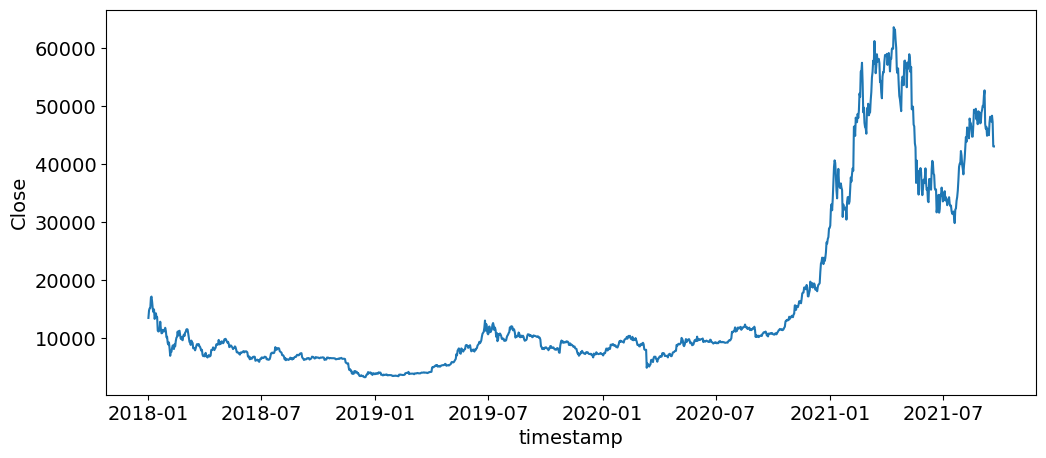

In [50]:
train_mini = train[train.Asset_ID == 1].reset_index()

train_mini = train_mini[['timestamp','Close']].resample('D', on='timestamp').last()['Close']
train_mini = train_mini.to_frame().reset_index(drop=False)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,5))

sns.lineplot(data=train_mini, x='timestamp', y='Close')
plt.show()

### 1. Check Stationarity
The sample data is non-stationary. Therefore, we need to difference the time series.

In [51]:
check_stationarity(train_mini['Close'])

train_mini['Close_diff'] = train_mini['Close'].diff().fillna(0)

check_stationarity(train_mini['Close_diff'])

ADF Statistic: -0.422392
p-value: 0.906293
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
Non-stationary
ADF Statistic: -7.377094
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
Stationary


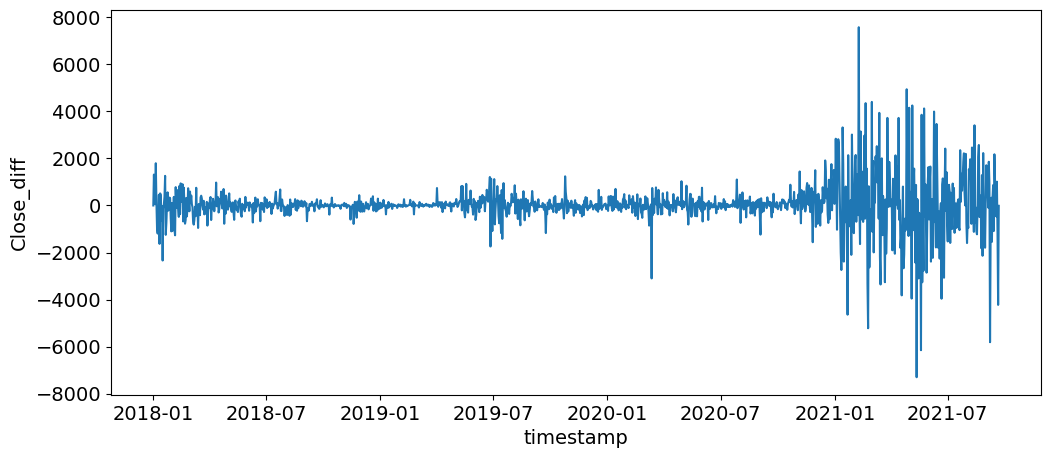

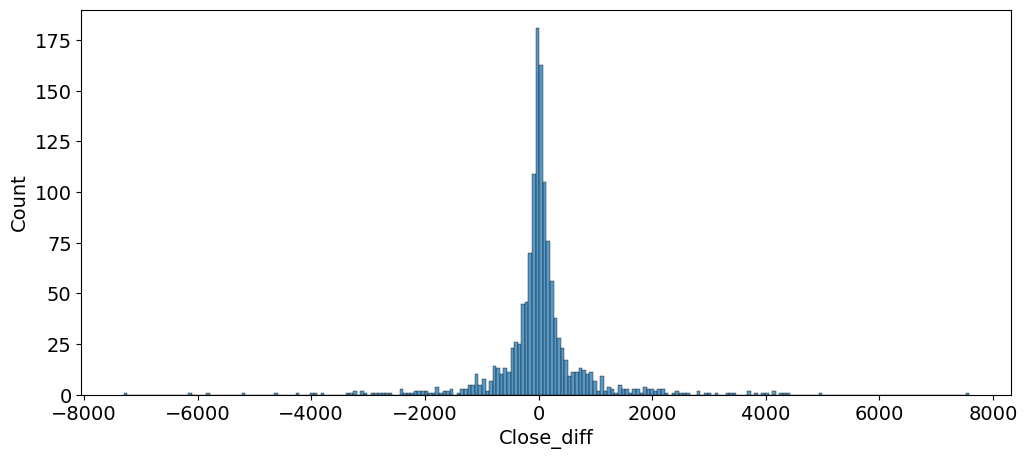

In [52]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,5))

sns.lineplot(data=train_mini, x='timestamp', y='Close_diff')
plt.show()

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,5))

sns.histplot(train_mini['Close_diff'] )
plt.show()

### 2. Check ACF and PACF

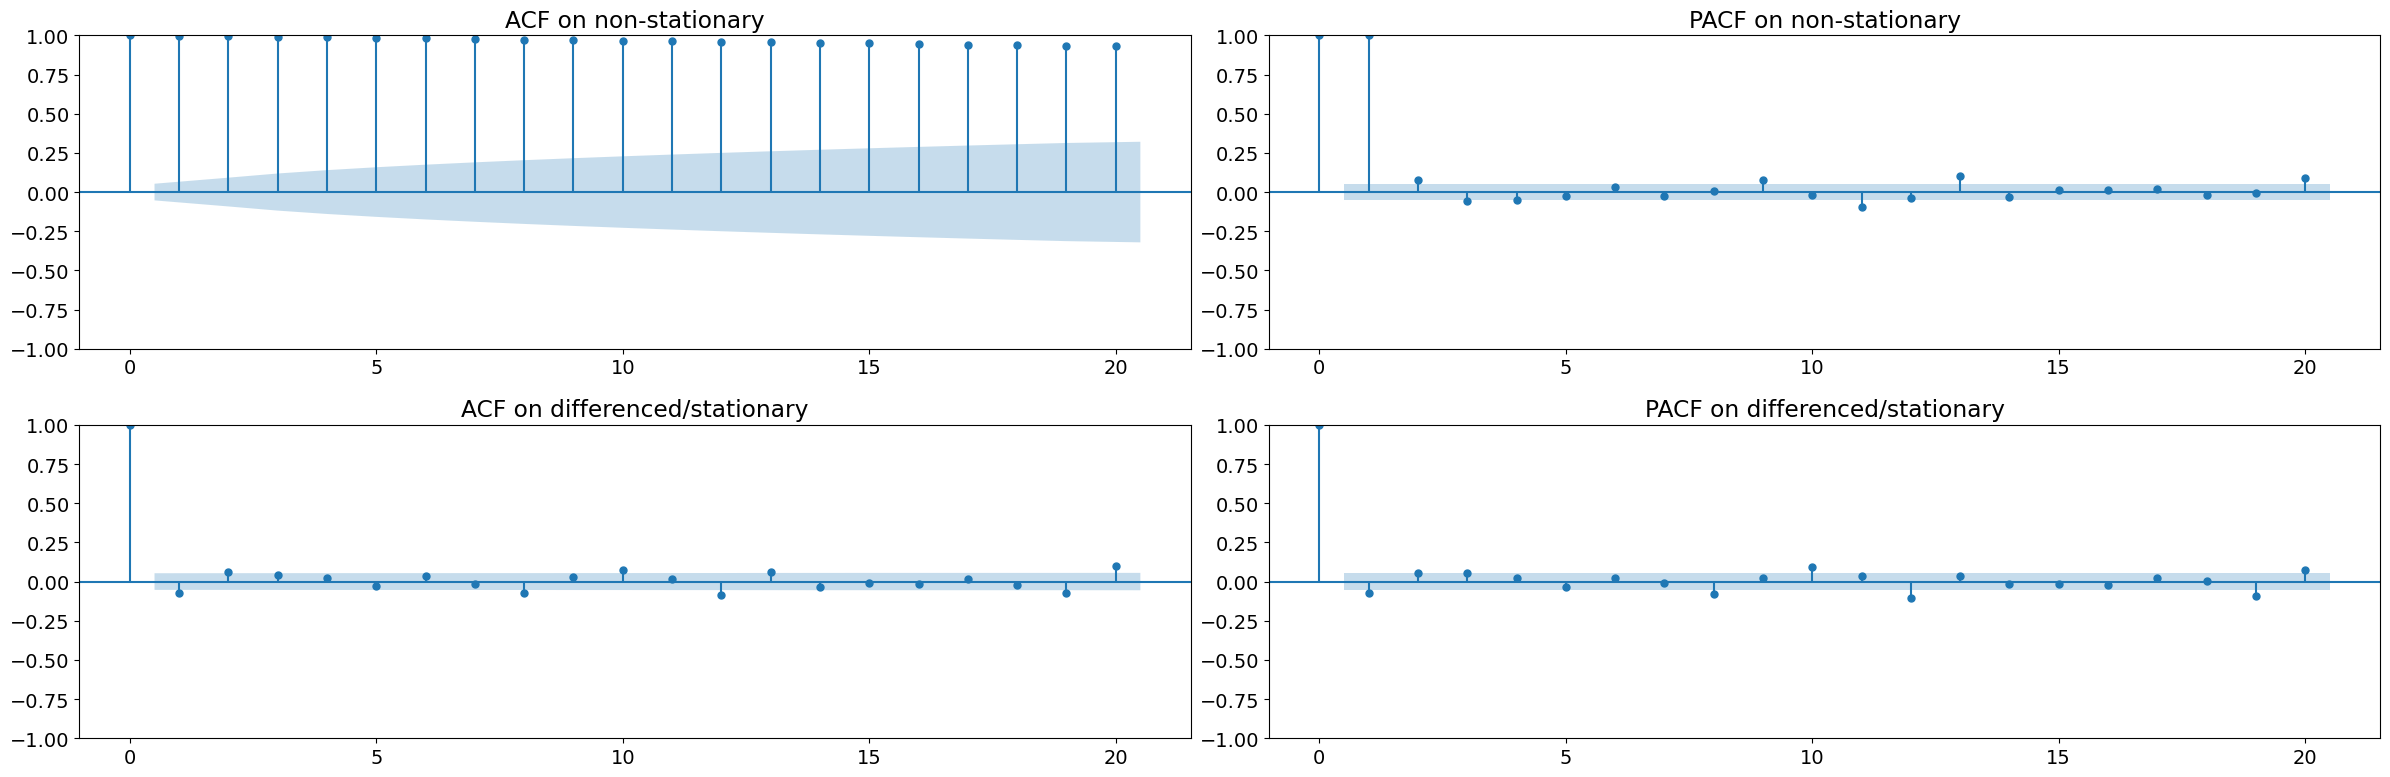

In [53]:
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(2*width, 2*height))

plot_acf(train_mini['Close'], lags=20, ax=ax[0, 0], title='ACF on non-stationary')
plot_pacf(train_mini['Close'], lags=20, ax=ax[0, 1], method='ols', title='PACF on non-stationary')

plot_acf(train_mini['Close_diff'], lags=20, ax=ax[1, 0], title='ACF on differenced/stationary')
plot_pacf(train_mini['Close_diff'], lags=20, ax=ax[1, 1], method='ols', title='PACF on differenced/stationary')

plt.tight_layout()
plt.show()

## Ethereum

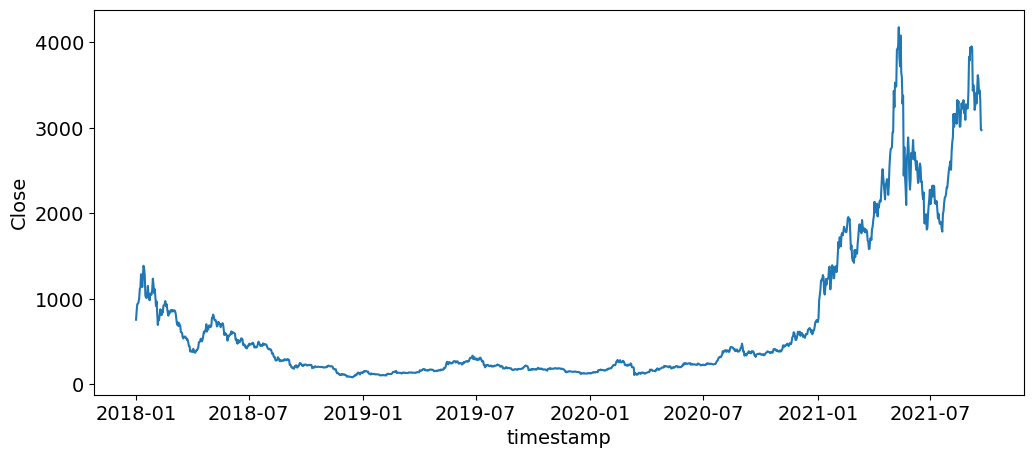

In [54]:
train_mini = train[train.Asset_ID == 6].reset_index()

train_mini = train_mini[['timestamp','Close']].resample('D', on='timestamp').last()['Close']
train_mini = train_mini.to_frame().reset_index(drop=False)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,5))

sns.lineplot(data=train_mini, x='timestamp', y='Close')
plt.show()

### 1. Check Stationarity
The sample data is non-stationary. Therefore, we need to difference the time series.

In [55]:
check_stationarity(train_mini['Close'])

train_mini['Close_diff'] = train_mini['Close'].diff().fillna(0)

check_stationarity(train_mini['Close_diff'])

ADF Statistic: 0.149049
p-value: 0.969255
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
Non-stationary
ADF Statistic: -10.075336
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
Stationary


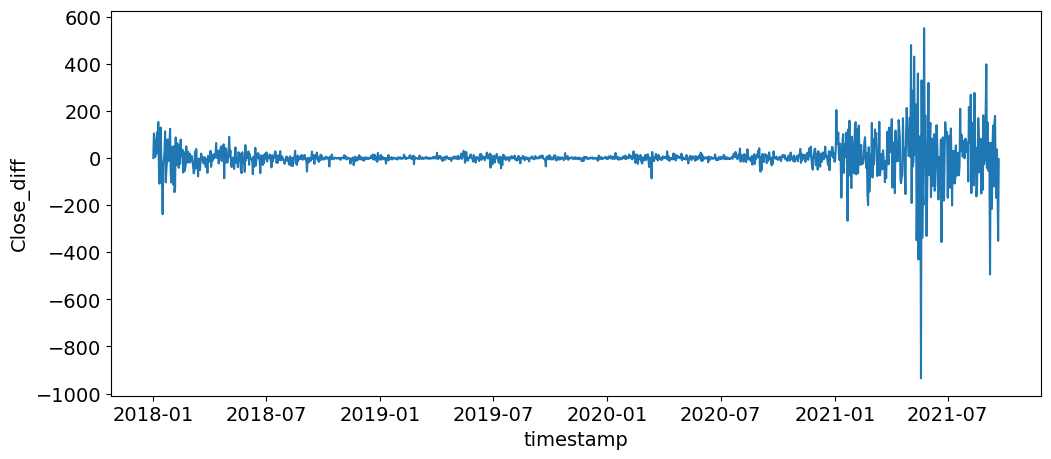

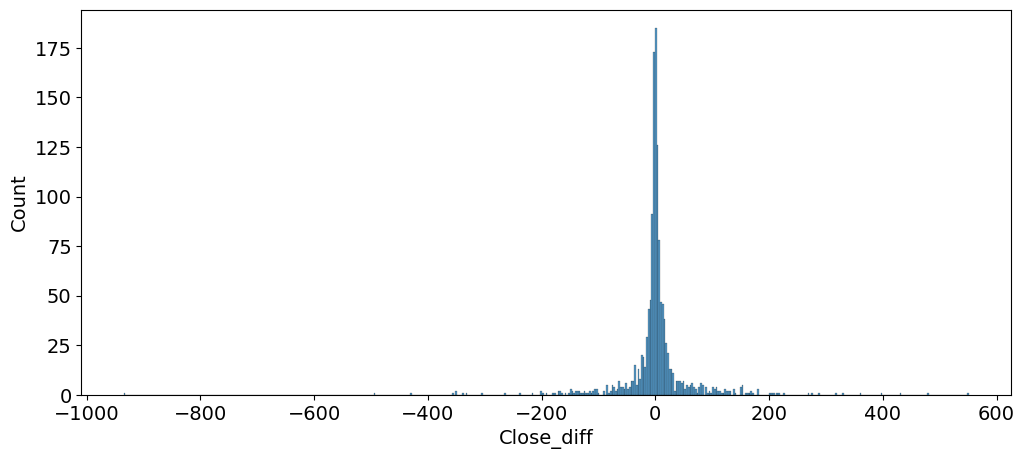

In [56]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,5))

sns.lineplot(data=train_mini, x='timestamp', y='Close_diff')
plt.show()

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,5))

sns.histplot(train_mini['Close_diff'] )
plt.show()

### 2. Check ACF and PACF

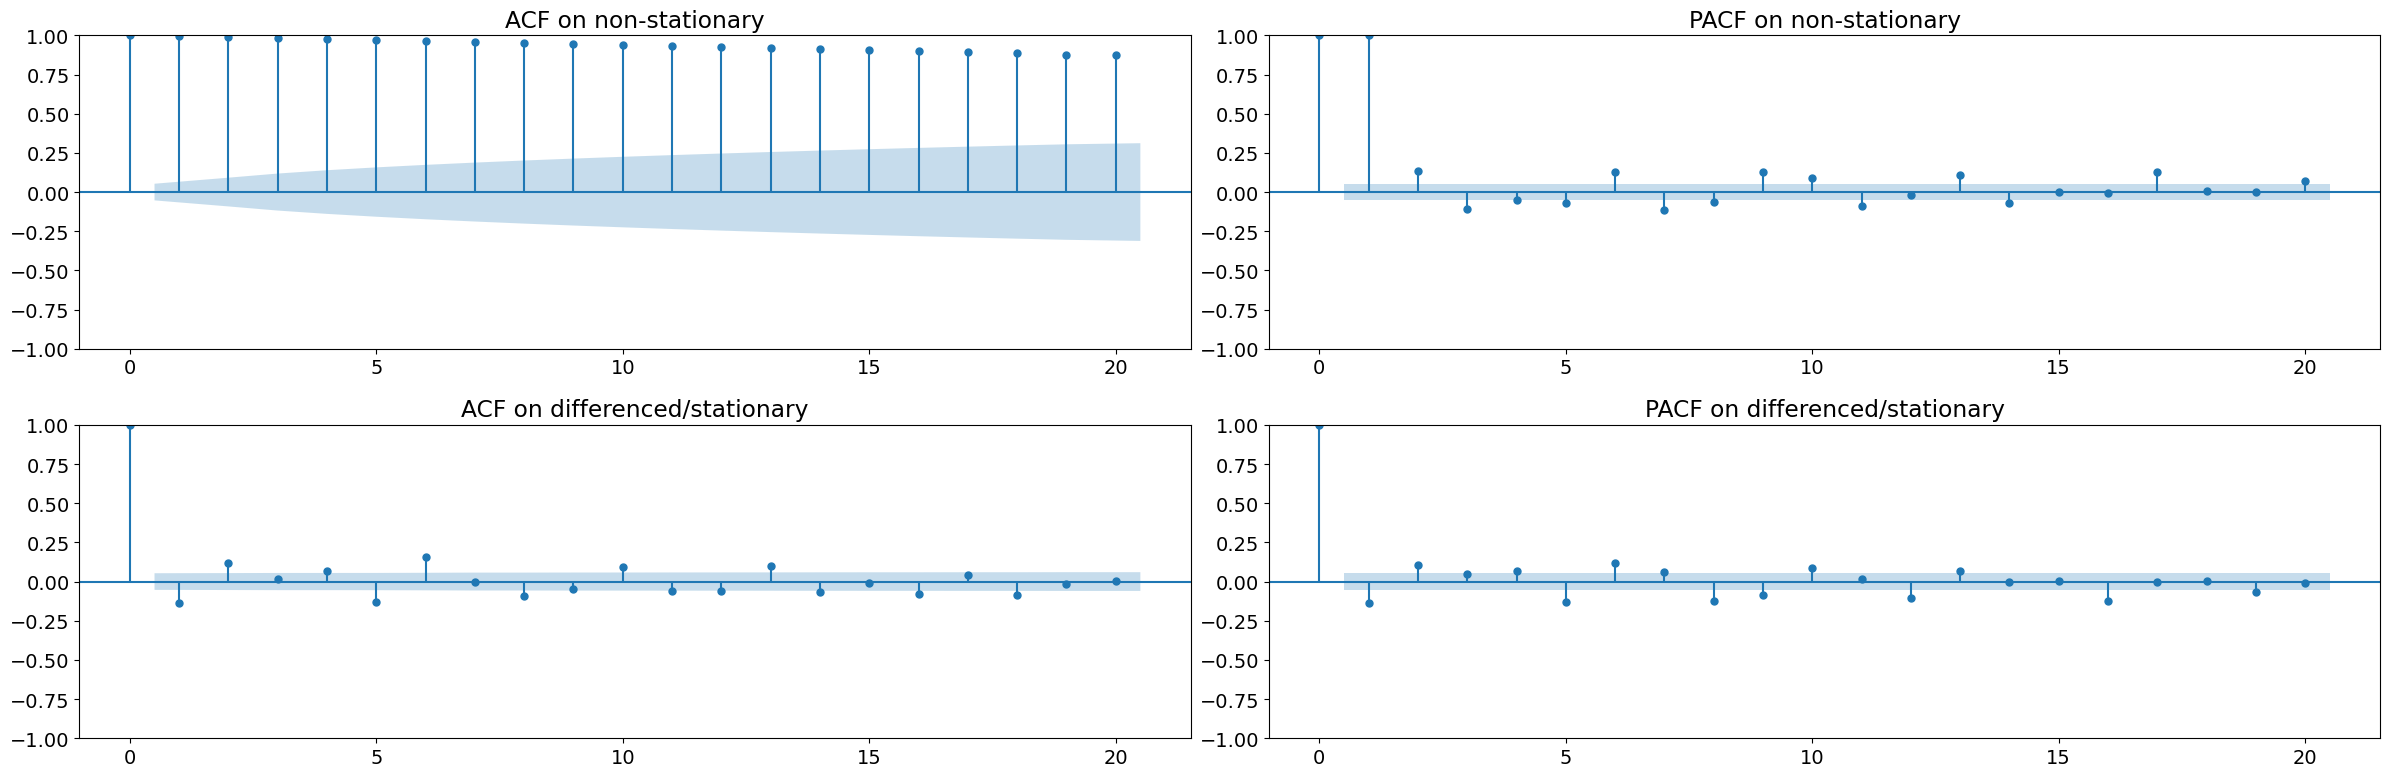

In [57]:
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(2*width, 2*height))

plot_acf(train_mini['Close'], lags=20, ax=ax[0, 0], title='ACF on non-stationary')
plot_pacf(train_mini['Close'], lags=20, ax=ax[0, 1], method='ols', title='PACF on non-stationary')

plot_acf(train_mini['Close_diff'], lags=20, ax=ax[1, 0], title='ACF on differenced/stationary')
plot_pacf(train_mini['Close_diff'], lags=20, ax=ax[1, 1], method='ols', title='PACF on differenced/stationary')

plt.tight_layout()
plt.show()

## Discussion on Random-Walk
For both Bitcoin and Ethereum, we can observe a **random-walk** behavior (see [🚀 Cheat Sheet](#🚀-Cheat-Sheet)). This is fairly common in stock prices (see [Random Walk Theory](https://www.investopedia.com/terms/r/randomwalktheory.asp))

> A **random walk is unpredictable**; it cannot reasonably be predicted.
>
> Given the way that the random walk is constructed, we can expect that the best prediction we could make would be to use the observation at the previous time step as what will happen in the next time step.
>
>Simply because we know that the next time step will be a function of the prior time step.
>
>This is often called the naive forecast, or a persistence model. - [A Gentle Introduction to the Random Walk for Times Series Forecasting with Python](https://machinelearningmastery.com/gentle-introduction-random-walk-times-series-forecasting-python/)

Well, that's an unsatisfying finding. So, where do we go from here?